# Visualize version 3

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re


class VisualizeTestPred:
    def __init__(self, test_url, real_url):
        section_name_map = {
            "Project Description / Purpose": "Project Description",
            "Project Overview": "Project Overview",
            "Timeline": "Timeline",
            "Project Scope": "Project Scope",
            "Project Team": "Project Team"
        }
        self.test_url = test_url
        self.real_url = real_url

        self.real_df = pd.read_csv(self.real_url)
        self.real_df = self.real_df.rename(columns={'description': 'Section'})
        self.real_df = self.real_df[['user_id','Section','score', 'grader_name', 'grader_comment']]

        self.test_df = pd.read_csv(self.test_url)
        self.test_df = self.test_df.rename(columns={'File_Name': 'user_id'})
        self.test_df['Section'] = self.test_df['Section'].replace(section_name_map)
        self.test_df = self.filter_users_with_all_criteria(self.test_df)

        self.merged_df = pd.merge(self.test_df, self.real_df, on=['user_id', 'Section'], how='left')
        self.merged_df = self.merged_df.rename(columns={'score': 'Real_Grade'})

        self.pred_true = self.aggregateTestRealResult(self.test_url, self.real_url)
    
    # Drop ids that don't have enough criteria data in it
    # Group by user_id and check if each user_id has all required criteria
    def filter_users_with_all_criteria(self, df):
        """
        Function to filter out user_ids that do not have all required criteria.
        
        Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        required_criteria (set): The set of required criteria.
        
        Returns:
        pd.DataFrame: A filtered DataFrame containing only user_ids with all required criteria.
        """
        required_criteria = set(df['Criteria'].unique())
        # Group by user_id and check if each user_id has all required criteria
        user_criteria_check = df.groupby('user_id')['Criteria'].apply(lambda x: required_criteria.issubset(set(x))).reset_index()
        user_criteria_check.columns = ['user_id', 'has_all_criteria']
        
        # Filter out user_ids that do not have all required criteria
        valid_user_ids = user_criteria_check[user_criteria_check['has_all_criteria']]['user_id']
        filtered_df = df[df['user_id'].isin(valid_user_ids)]
        
        return filtered_df

    # Aggregate the test result and real result
    def aggregateTestRealResult(self, test_results_url, real_results_url):
        section_name_map = {
            "Project Description / Purpose": "Project Description",
            "Project Overview": "Project Overview",
            "Timeline": "Timeline",
            "Project Scope": "Project Scope",
            "Project Team": "Project Team"
        }
        result_df = pd.read_csv(test_results_url, index_col=0).reset_index(drop=True)
        result_df['AI_Grade'] = pd.to_numeric(result_df['AI_Grade'], errors='coerce')
        result_df = result_df.drop_duplicates(subset=['File_Name','Section', 'Criteria'], keep='first').reset_index(drop=True)
        print("Number of unique file: ", result_df['File_Name'].nunique())
        grouped_df = result_df.groupby(['File_Name', 'Section']).agg({
            'AI_Grade': 'sum',
            'Comment': lambda x: ' '.join(x)
        }).reset_index()

        # Display the resulting DataFrame
        grouped_df['Section'] = grouped_df['Section'].replace(section_name_map)
        final_test_df = grouped_df[['File_Name', 'Section', 'AI_Grade', 'Comment']]
        final_test_df = final_test_df.rename(columns={'File_Name': 'user_id'})

        final_true_df = pd.read_csv(real_results_url)
        final_true_df = final_true_df.rename(columns={'description': 'Section'})

        final_trainig_df = pd.merge(final_test_df, final_true_df, on=['user_id', 'Section'], how='left')
        final_trainig_df = final_trainig_df.rename(columns={'Comment': 'AI_Comment'})
        return final_trainig_df
    
    def check_grades(self, section=None, criteria=None):
        is_wrong = []
        temp_df = self.merged_df.copy()
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
            if criteria != None:
                temp_df = temp_df[temp_df['Criteria'] == criteria]
        for index, row in temp_df.iterrows():
            if row['AI_Grade'] != row['Real_Grade']:
                if row['user_id'] not in is_wrong:
                    print("-" * 40)
                    is_wrong.append(row['user_id'])
                    print(f"User ID: {row['user_id']}")
                print(f"\nSection: {row['Section']}")
                print(f"Criteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")
                print(f"Human Grade: {row['Real_Grade']}")
                print(f"Human Comment: {row['grader_comment']}")
    
    def plot_failed_submissions(self, section=None):
        is_wrong = []
        temp_df = self.merged_df.copy()
        
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
        print("Number of file: ", temp_df['user_id'].nunique())
        failed_submissions_id = temp_df[temp_df['Real_Grade'] == 0]['user_id'].unique()
        for id in failed_submissions_id:
            print("-" * 40)
            failed_id_df = temp_df[temp_df['user_id'] == id]
            print(f"user id: {id}")
            print(f"Human Grade: {failed_id_df['Real_Grade'].iloc[0]}")
            print(f"Human Comment: {failed_id_df['grader_comment'].iloc[0]}")
            for index, row in failed_id_df.iterrows():
                print(f"\nSection: {row['Section']}")
                print(f"Criteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")
    
    def visualize_difference_between_AI_and_Real_Grade(self, section):
        result_df = self.pred_true
        result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
        visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_name']]
        description_df = visualize_df[visualize_df['Section'] == section]
        # Separate the data into two DataFrames based on RealGrade
        real_grade_0 = description_df[description_df['Real_Grade'] == 0]
        real_grade_1 = description_df[description_df['Real_Grade'] == 1]

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        fig.suptitle('Difference between AI and Real Grade for Section ' + section, fontsize=20)
        # Scatter plot for RealGrade = 0
        sns.scatterplot(ax=axes[0], x=real_grade_0.index, y=real_grade_0['AI_Grade'], color='blue')
        axes[0].set_title('AI grade when RealGrade = 0')
        axes[0].set_xlabel('Submission Index')
        axes[0].set_ylabel('AI grade')

        # Scatter plot for RealGrade = 1
        sns.scatterplot(ax=axes[1], x=real_grade_1.index, y=real_grade_1['AI_Grade'], color='green')
        axes[1].set_title('AI grade when RealGrade = 1')
        axes[1].set_xlabel('Submission Index')

    def plot_false_positive(self, section):
        # Get the false positive data
        result_df = self.pred_true
        result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
        visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_comment', 'AI_Comment']]
        description_df = visualize_df[visualize_df['Section'] == section]
        false_positive = description_df[(description_df['AI_Grade'] == max(visualize_df['AI_Grade'])) & (description_df['Real_Grade'] == 0)]
        false_positive = false_positive.sort_values(by='AI_Grade', ascending=False)
        false_positive_id = false_positive['user_id'].unique()

        # From false positive ID print out the information
        temp_df = self.merged_df.copy()
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
        print("Number of false positive: ", false_positive['user_id'].nunique())
        for id in false_positive_id:
            print("-" * 40)
            false_positive_df = temp_df[temp_df['user_id'] == id]
            print(f"user id: {id}")
            print(f"Human Grade: {false_positive_df['Real_Grade'].iloc[0]}")
            print(f"Human Comment: {false_positive_df['grader_comment'].iloc[0]}")
            for index, row in false_positive_df.iterrows():
                if section == None:
                    print(f"\nSection: {row['Section']}")
                print(f"\nCriteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")

    def plot_false_negative(self, section):
        # Get the false negative data
        result_df = self.pred_true
        result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
        visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_comment', 'AI_Comment']]
        description_df = visualize_df[visualize_df['Section'] == section]
        false_negative = description_df[(description_df['AI_Grade'] < max(visualize_df['AI_Grade'])) & (description_df['Real_Grade'] == 1)]
        false_negative = false_negative.sort_values(by='AI_Grade', ascending=False)
        false_negative_id = false_negative['user_id'].unique()

        # From false negative ID print out the information
        temp_df = self.merged_df.copy()
        if section != None:
            temp_df = temp_df[temp_df['Section'] == section]
        print("Number of false positive: ", false_negative['user_id'].nunique())
        for id in false_negative_id:
            print("-" * 40)
            false_negative_df = temp_df[temp_df['user_id'] == id]
            print(f"user id: {id}")
            print(f"Human Grade: {false_negative_df['Real_Grade'].iloc[0]}")
            print(f"Human Comment: {false_negative_df['grader_comment'].iloc[0]}")
            for index, row in false_negative_df.iterrows():
                if section == None:
                    print(f"\nSection: {row['Section']}")
                print(f"\nCriteria: {row['Criteria']}")
                print(f"AI Grade: {row['AI_Grade']}")
                print(f"AI Comment: {row['Comment']}")
    
    def plot_confusion_matrix_by_question(self, section):
        result_df = self.merged_df.copy()
        description_df = result_df[result_df['Section'] == section]
        
        # Get the question list
        question_list = description_df['Criteria'].unique()
        print("question_list: ",question_list)
        # Create a figure with multiple subplots
        for question in question_list:
            q = question
            match = re.match(r'(Question \d+)', question)
            if match:
                q = match.group(1)
            q_df = description_df[description_df['Criteria'].str.contains(q, case=False, na=False)]
            # Calculate the confusion matrix
            cm = confusion_matrix(q_df['Real_Grade'], q_df['AI_Grade'])

            # Create a DataFrame for the confusion matrix
            cm_df = pd.DataFrame(cm, index=['Fail', 'Pass'], columns=['Fail', 'Pass'])

            # Plot the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix for ' + question)
            plt.ylabel('Real Grade')
            plt.xlabel('AI Grade')
            plt.show()

        description_df['Short_Section'] = description_df['Criteria'].str.extract(r'(Question \d+)')

        # List of questions
        questions = description_df['Short_Section'].unique()
        # Initialize lists to store counts
        human_1_ai_1_counts = []
        human_1_ai_0_counts = []
        human_0_ai_1_counts = []
        human_0_ai_0_counts = []

        # Calculate the counts for each question
        for question in questions:
            human_1_ai_1_counts.append(description_df[(description_df['Short_Section'] == question) & (description_df['Real_Grade'] == 1) & (description_df['AI_Grade'] == 1)].shape[0])
            human_1_ai_0_counts.append(description_df[(description_df['Short_Section'] == question) & (description_df['Real_Grade'] == 1) & (description_df['AI_Grade'] == 0)].shape[0])
            human_0_ai_1_counts.append(description_df[(description_df['Short_Section'] == question) & (description_df['Real_Grade'] == 0) & (description_df['AI_Grade'] == 1)].shape[0])
            human_0_ai_0_counts.append(description_df[(description_df['Short_Section'] == question) & (description_df['Real_Grade'] == 0) & (description_df['AI_Grade'] == 0)].shape[0])

        # Create a DataFrame for plotting
        data = {
            'Human Grade 1 - AI Grade 1': human_1_ai_1_counts,
            'Human Grade 1 - AI Grade 0': human_1_ai_0_counts,
            'Human Grade 0 - AI Grade 1': human_0_ai_1_counts,
            'Human Grade 0 - AI Grade 0': human_0_ai_0_counts
        }
        df = pd.DataFrame(data, index=questions)

        # Plot the stacked columns
        ax = df.plot(kind='bar', stacked=True, figsize=(14, 8), color=['blue', 'red', 'green', 'gray'])

        # Add labels and title
        plt.xlabel('Questions')
        plt.ylabel('Count')
        plt.title('Stacked Columns of AI Grade and Human Grade for Each Question')
        plt.xticks(rotation=45)
        plt.legend(title='Grade Combinations', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Show the plot
        plt.tight_layout()
        plt.show()

    def plot_overall_confusion_matrix(self):
        grouped_df = self.merged_df.groupby(['user_id', 'Section']).agg(
            sum_ai_grade=pd.NamedAgg(column='AI_Grade', aggfunc='sum'),
            sum_human_grade=pd.NamedAgg(column='Real_Grade', aggfunc='sum')
        ).reset_index()

        # Create Pass_AI and Pass_human columns
        grouped_df['Pass_AI'] = grouped_df['sum_ai_grade'].apply(lambda x: 1 if x >= 3 else 0)
        grouped_df['Pass_human'] = grouped_df['sum_human_grade'].apply(lambda x: 1 if x == 3 else 0)

        # Create confusion matrix
        cm = confusion_matrix(grouped_df['Pass_human'], grouped_df['Pass_AI'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail', 'Pass'])

        # Plot confusion matrix
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix for AI and Human Grades')
        plt.xlabel('Graded by AI')
        plt.ylabel('Graded by human')
        plt.show()

In [147]:
test_url = 'test_results/test_result_on_56_files_0_1.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.check_grades('Project Description')

Number of unique file:  56
----------------------------------------
User ID: 593636371

Section: Project Description
Criteria: Question 5. Does the value of the 'TIP 2.0 Process Milestone:' attribute provide specific process milestone details?
AI Grade: 0
AI Comment: The value does not provide specific process milestone details.
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail.


Section: Project Description
Criteria: Question 8. Does the value of the 'Project Description / Purpose' attribute include detailed expected results from the project?
AI Grade: 0
AI Comment: The project description does not include detailed expected results from the project.
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail.

----------------------------------------
User ID: 593636611

Section: Project Description
Criteria: Question 8. Does the value of the 'Project Description / Purpose' attribut

# Visualize version 3

In [148]:
result_df = pd.read_csv('56_files_pred_true_version3.csv')
# Rename columns
result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_name']]
visualize_df

,user_id,Section,Criteria,AI_Grade,Real_Grade,grader_name
0,593636371,Project Description,Includes a brief description of the project.<b...,6,1.0,Kailey Love
1,593636371,Project Overview,Describes problem or performance gap with desc...,3,1.0,Kailey Love
2,593636371,Project Scope,Explains objectives that are in scope.<br/>\r\...,2,1.0,Kailey Love
3,593636371,Project Team,Identifies:<br/>\r\n<br/>\r\n1. Team Lead<br/>...,6,1.0,Kailey Love
4,593636371,Timeline,Lists each key task and planned completion dates.,2,1.0,Kailey Love
...,...,...,...,...,...,...
250,596799191,Project Description,Includes a brief description of the project.<b...,6,1.0,Samantha Basch
251,596799191,Project Overview,Describes problem or performance gap with desc...,3,1.0,Samantha Basch
252,596799191,Project Scope,Explains objectives that are in scope.<br/>\r\...,1,1.0,Samantha Basch
253,596799191,Project Team,Identifies:<br/>\r\n<br/>\r\n1. Team Lead<br/>...,7,1.0,Samantha Basch


## Visualize Description

### Mulltivariate graph

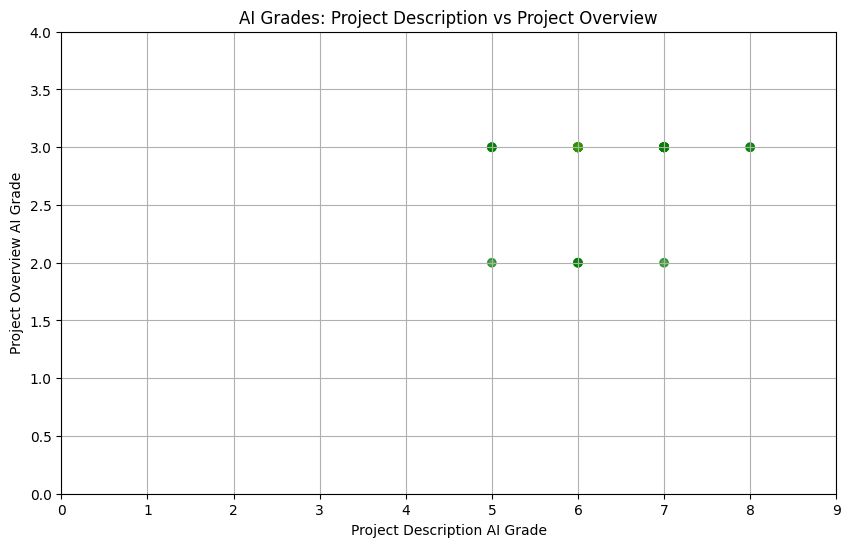

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_section_grades(section1, section2, csv_file='56_files_pred_true_version3.csv'):
    """
    Function to plot AI grades for two sections and color based on Real_Grade.
    
    Parameters:
    section1 (str): The first section name.
    section2 (str): The second section name.
    csv_file (str): The path to the CSV file containing the data.
    
    Returns:
    None
    """
    # Read the CSV file
    result_df = pd.read_csv(csv_file)
    
    # Rename columns
    result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
    
    # Filter data for the specified sections
    filtered_df = result_df[result_df['Section'].isin([section1, section2])]
    
    # Pivot the DataFrame to have AI grades for the specified sections
    pivot_df = filtered_df.pivot(index='user_id', columns='Section', values='AI_Grade')
    
    # Drop rows with missing values
    pivot_df.dropna(inplace=True)
    
    # Merge the Real_Grade column back to the pivoted DataFrame
    real_grades = filtered_df.pivot(index='user_id', columns='Section', values='Real_Grade')
    pivot_df = pivot_df.merge(real_grades, on='user_id', suffixes=('_AI', '_Real'))
    
    # Define colors based on Real_Grade for the specified sections
    def get_color(row):
        if row[f'{section1}_Real'] == 1 and row[f'{section2}_Real'] == 1:
            return 'green'
        elif row[f'{section1}_Real'] == 1 or row[f'{section2}_Real'] == 1:
            return 'yellow'
        elif row[f'{section1}_Real'] == 0 and row[f'{section2}_Real'] == 0:
            return 'red'
        else:
            return 'gray'
    
    pivot_df['color'] = pivot_df.apply(get_color, axis=1)
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.scatter(pivot_df[f'{section1}_AI'], pivot_df[f'{section2}_AI'], c=pivot_df['color'], alpha=0.7)
    plt.title(f'AI Grades: {section1} vs {section2}')
    plt.xlabel(f'{section1} AI Grade')
    plt.ylabel(f'{section2} AI Grade')
    plt.xlim(0, pivot_df[f'{section1}_AI'].max() + 1)
    plt.ylim(0, pivot_df[f'{section2}_AI'].max() + 1)
    plt.grid(True)
    plt.show()

# Example usage
plot_section_grades('Project Description', 'Project Overview')

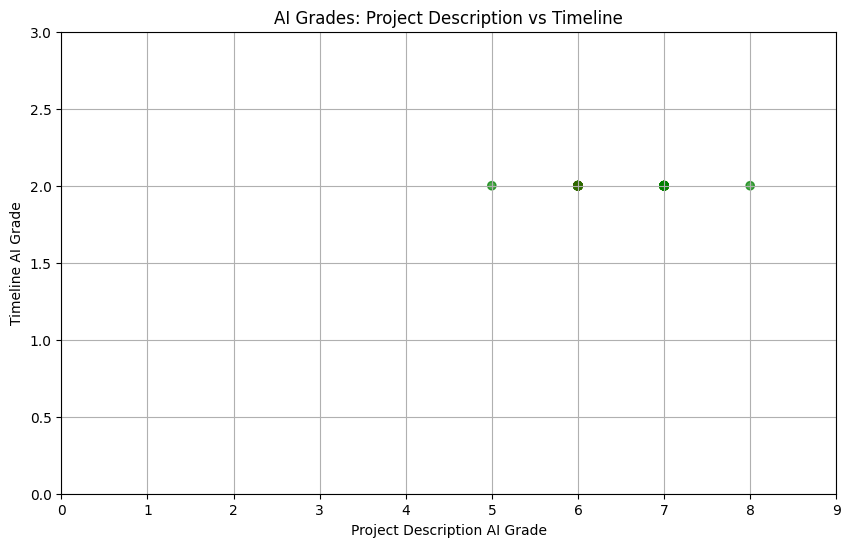

In [150]:
plot_section_grades('Project Description', 'Timeline')

### Histogram of AI score for each section

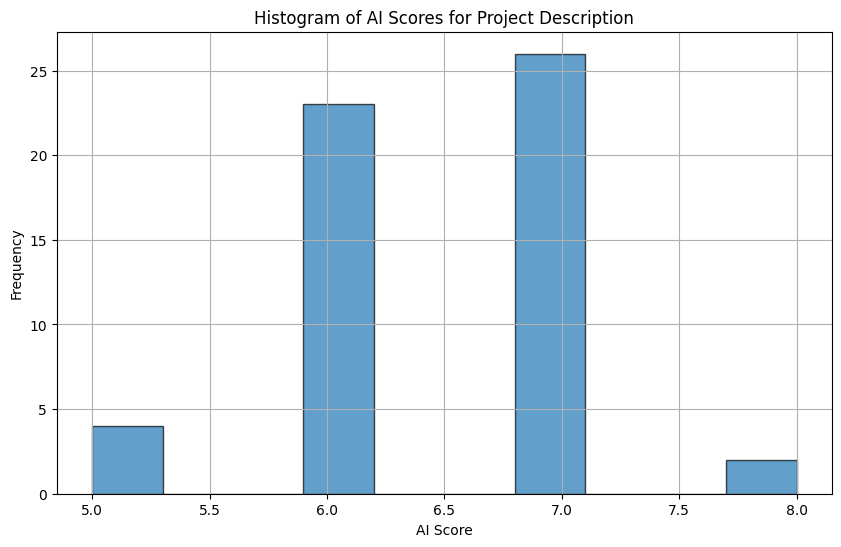

In [151]:
# Read the CSV file
def plot_section_histogram(section, url='56_files_pred_true_version3.csv'):
    """
    Function to plot a histogram of AI scores for a given section.
    
    Parameters:
    section (str): The section name.
    df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
    None
    """
    df = pd.read_csv(url)

    # Rename columns
    df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
    # Filter data for the specified section
    section_df = df[df['Section'] == section]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(section_df['AI_Grade'], bins=10, alpha=0.7, edgecolor='black')
    plt.title(f'Histogram of AI Scores for {section}')
    plt.xlabel('AI Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
plot_section_histogram('Project Description', '56_files_pred_true_version3.csv')

### AI difference for pass and fail submissions

In [152]:
def visualize_difference_between_AI_and_Real_Grade(url, section):
    result_df = pd.read_csv(url)
    result_df.rename(columns={'score': 'Real_Grade', 'long_description': 'Criteria'}, inplace=True)
    visualize_df = result_df[['user_id', 'Section', 'Criteria', 'AI_Grade', 'Real_Grade', 'grader_name']]
    description_df = visualize_df[visualize_df['Section'] == section]
    # Separate the data into two DataFrames based on RealGrade
    real_grade_0 = description_df[description_df['Real_Grade'] == 0]
    real_grade_1 = description_df[description_df['Real_Grade'] == 1]

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle('Difference between AI and Real Grade for Section ' + section, fontsize=20)
    # Scatter plot for RealGrade = 0
    sns.scatterplot(ax=axes[0], x=real_grade_0.index, y=real_grade_0['AI_Grade'], color='blue')
    axes[0].set_title('AI grade when RealGrade = 0')
    axes[0].set_xlabel('Submission Index')
    axes[0].set_ylabel('AI grade')

    # Scatter plot for RealGrade = 1
    sns.scatterplot(ax=axes[1], x=real_grade_1.index, y=real_grade_1['AI_Grade'], color='green')
    axes[1].set_title('AI grade when RealGrade = 1')
    axes[1].set_xlabel('Submission Index')



### Visualize AI Grade only

Number of files: 56


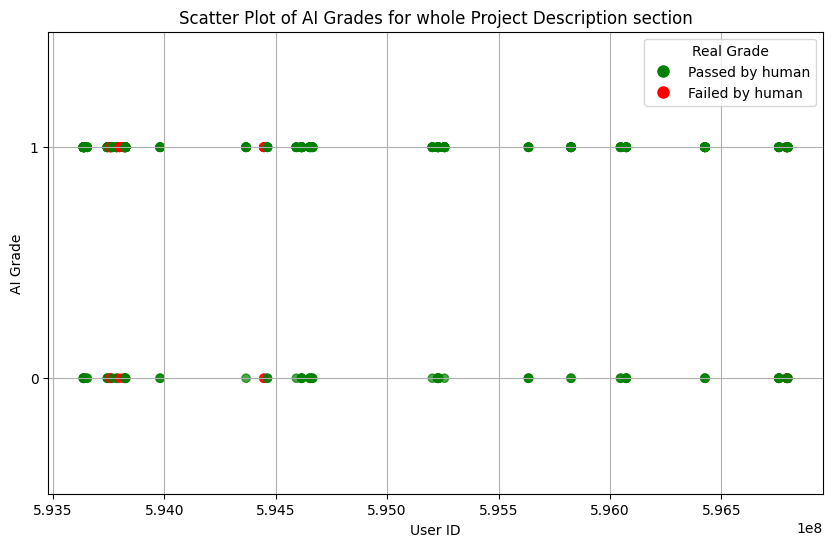

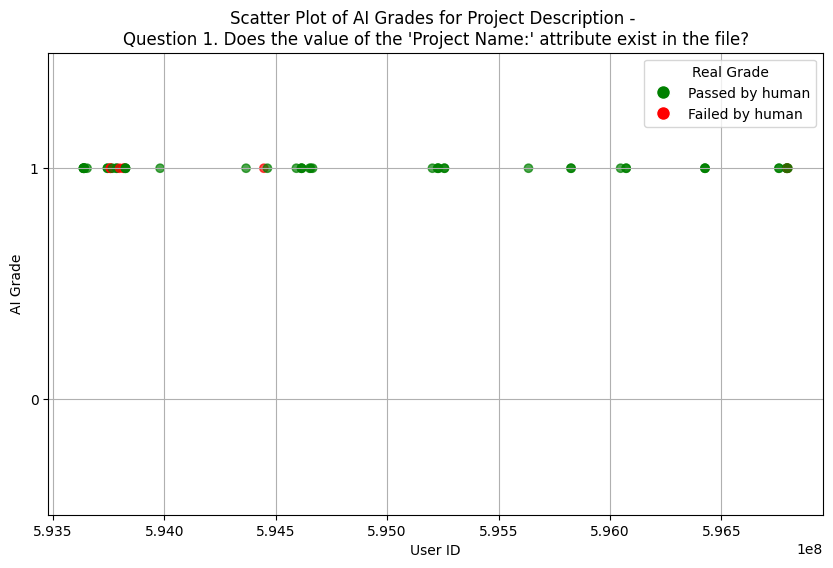

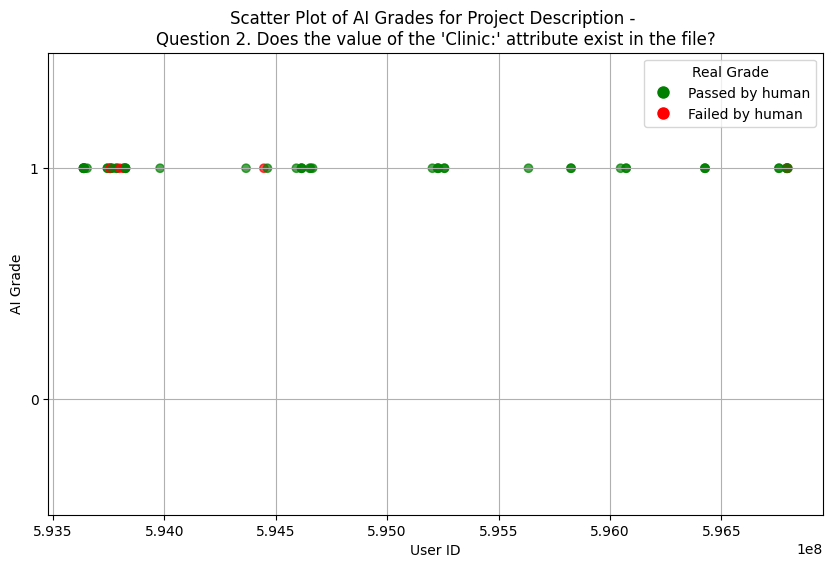

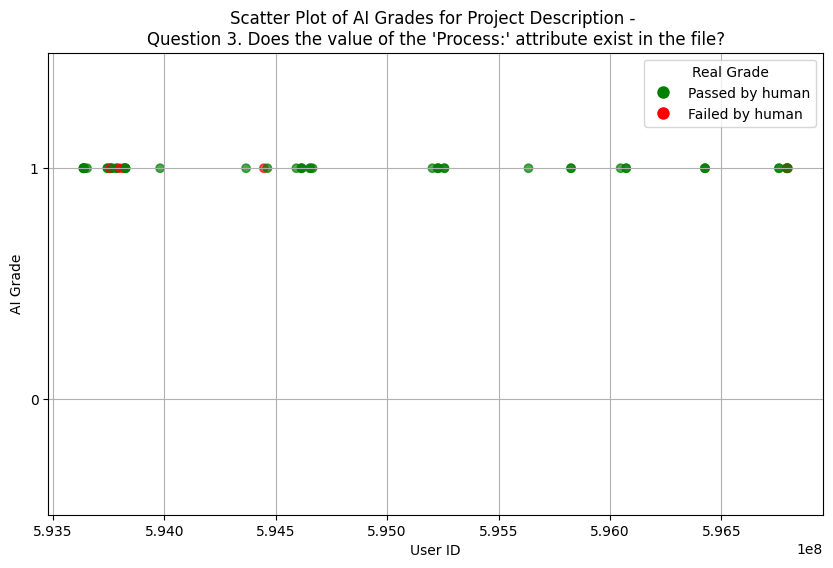

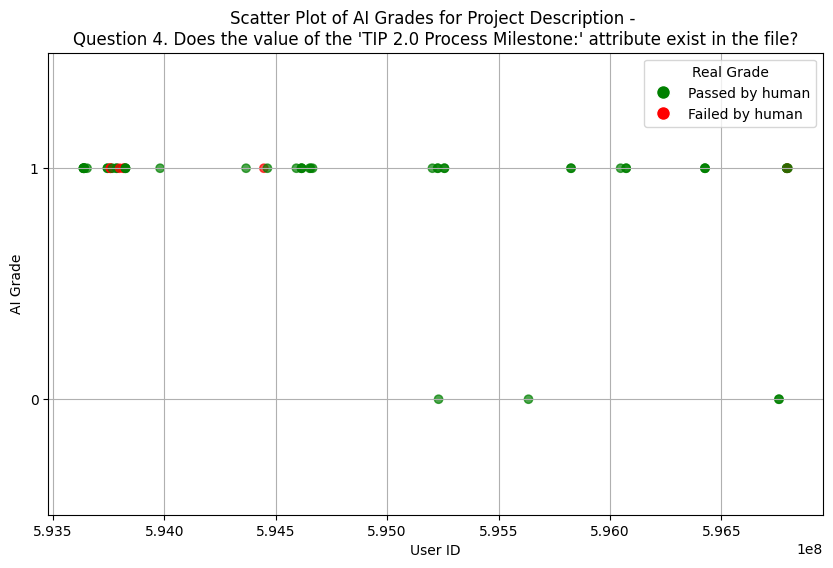

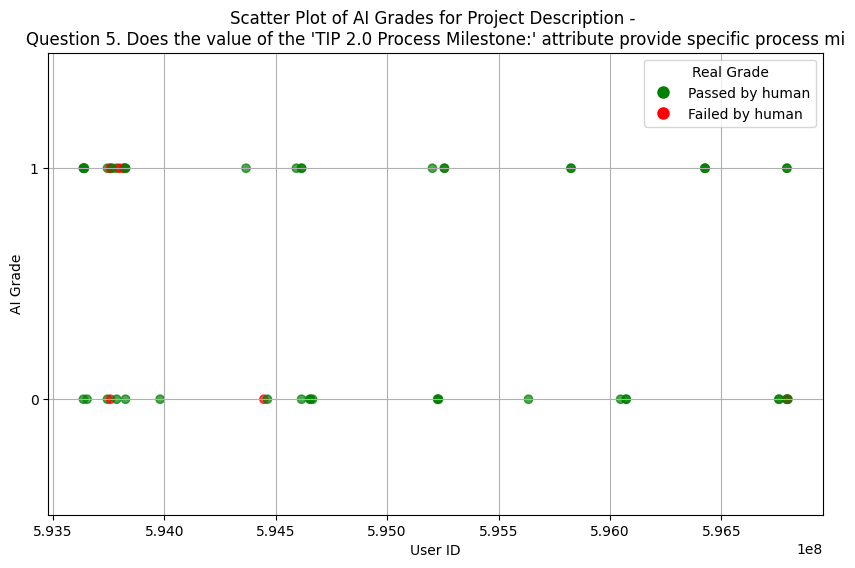

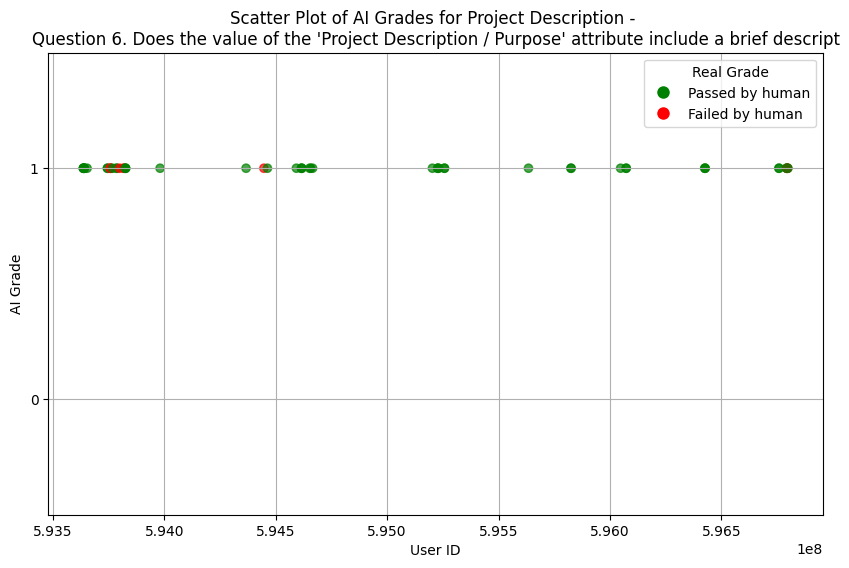

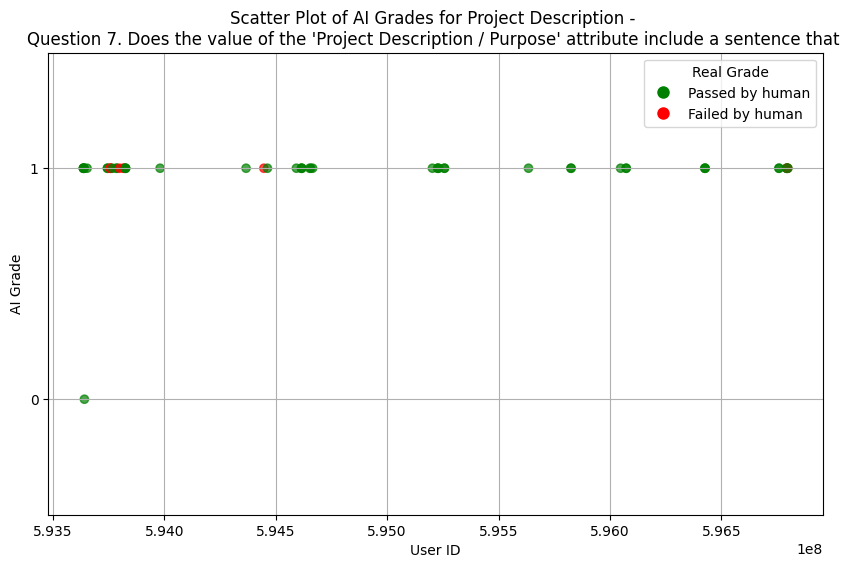

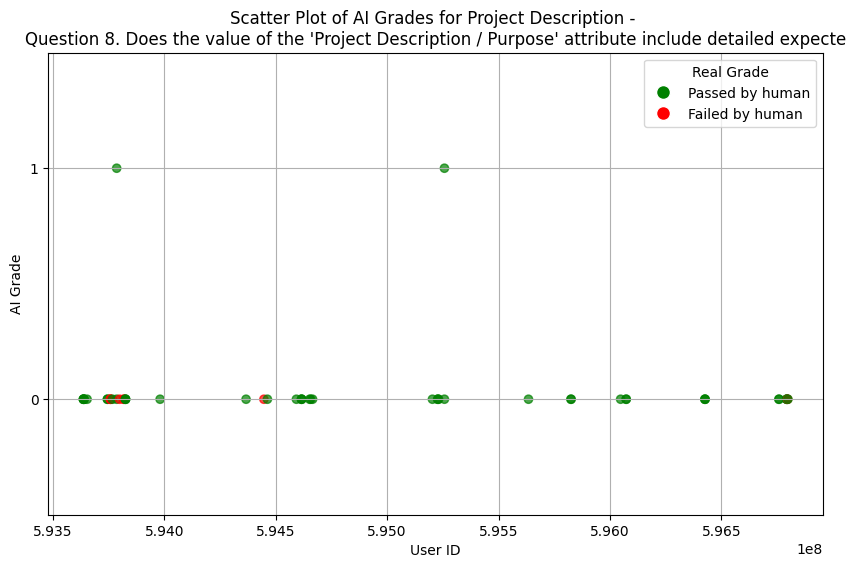

In [153]:
def plot_section_criteria_scatter(test_url,real_url,section):
    """
    Function to plot scatter plots of AI grades for each criteria within a given section.
    
    Parameters:
    section (str): The section name.
    df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
    None
    """
    section_name_map = {
        "Project Description / Purpose": "Project Description",
        "Project Overview": "Project Overview",
        "Timeline": "Timeline",
        "Project Scope": "Project Scope",
        "Project Team": "Project Team"
    }

    test_results = pd.read_csv(test_url, index_col=0).reset_index(drop=True)
    test_results = test_results.rename(columns={'File_Name': 'user_id'})
    test_results['Section'] = test_results['Section'].replace(section_name_map)

    real_results = pd.read_csv(real_url, index_col=0).reset_index(drop=True)
    real_results = real_results.rename(columns={'description': 'Section'})

    df = pd.merge(test_results, real_results[['user_id', 'Section', 'score']], on=['user_id', 'Section'], how='left')
    df = df.rename(columns={'score': 'Real_Grade'})

    print(f"Number of files: {df['user_id'].nunique()}")
    # Filter data for the specified section
    section_df = df[df['Section'] == section]

    # Get unique criteria for the section
    unique_criteria = section_df['Criteria'].unique()
    colors = section_df['Real_Grade'].apply(lambda x: 'green' if x == 1 else 'red')
    plt.figure(figsize=(10, 6))
    plt.scatter(section_df['user_id'], section_df['AI_Grade'], c=colors, alpha=0.7)
    plt.title(f'Scatter Plot of AI Grades for whole {section} section')
    plt.xlabel('User ID')
    plt.ylabel('AI Grade')
    plt.ylim(-0.5, 1.5)
    plt.yticks([0, 1])
    plt.grid(True)
    # Create a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Passed by human'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Failed by human')]
    plt.legend(handles=handles, title='Real Grade')
    plt.show()
    
    # Plot scatter plot for each criteria
    for criteria in unique_criteria:
        criteria_df = section_df[section_df['Criteria'] == criteria]
        colors = criteria_df['Real_Grade'].apply(lambda x: 'green' if x == 1 else 'red')
        plt.figure(figsize=(10, 6))
        plt.scatter(criteria_df['user_id'], criteria_df['AI_Grade'], c=colors, alpha=0.7)
        plt.title(f'Scatter Plot of AI Grades for {section} - \n{criteria[:100]}')
        plt.xlabel('User ID')
        plt.ylabel('AI Grade')
        plt.ylim(-0.5, 1.5)
        plt.yticks([0, 1])
        plt.grid(True)
        # Create a legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Passed by human'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Failed by human')]
        plt.legend(handles=handles, title='Real Grade')
        plt.show()

# Example usage
test_url = 'test_results/test_result_on_56_files_0_1.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
plot_section_criteria_scatter(test_url,real_url,'Project Description')

# Visualizer version 4 Description only

Number of files: 54


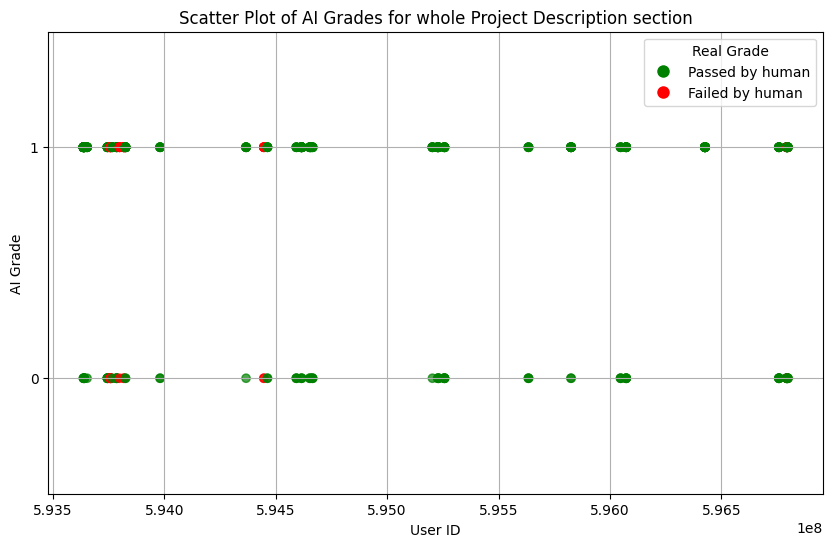

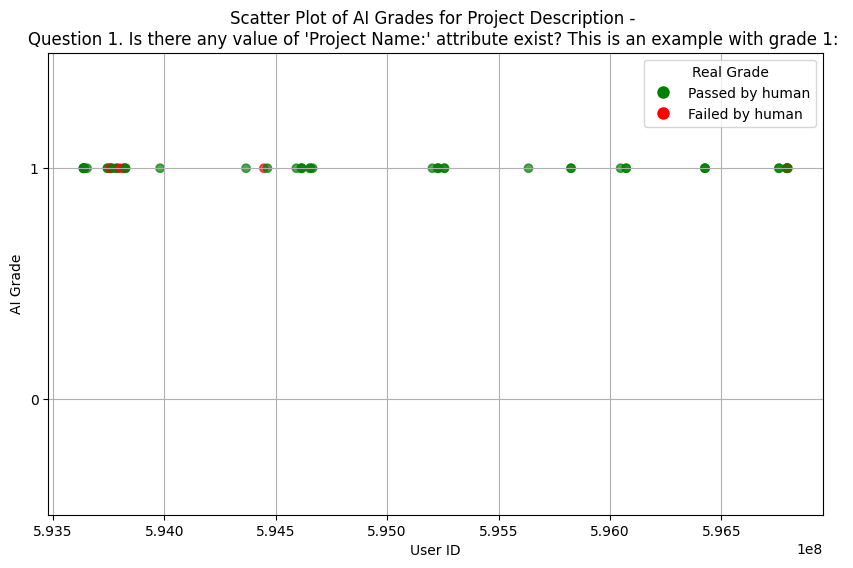

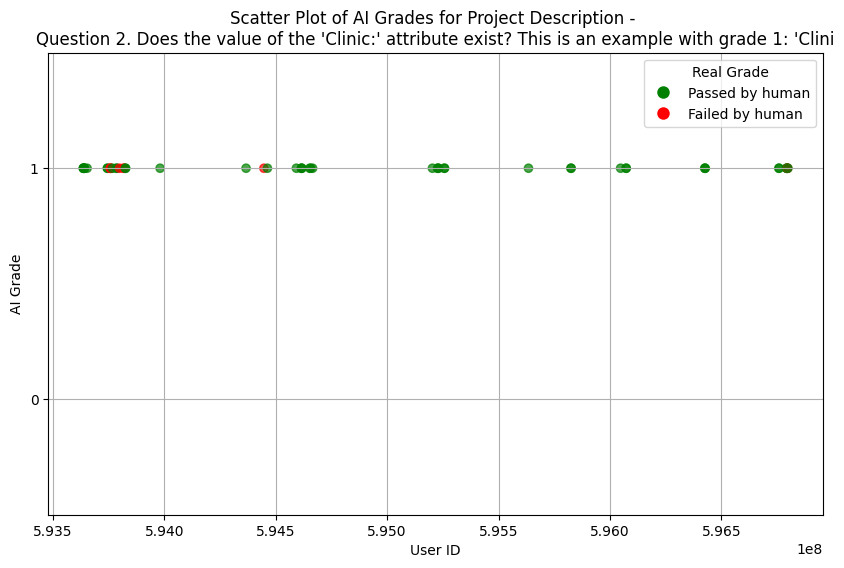

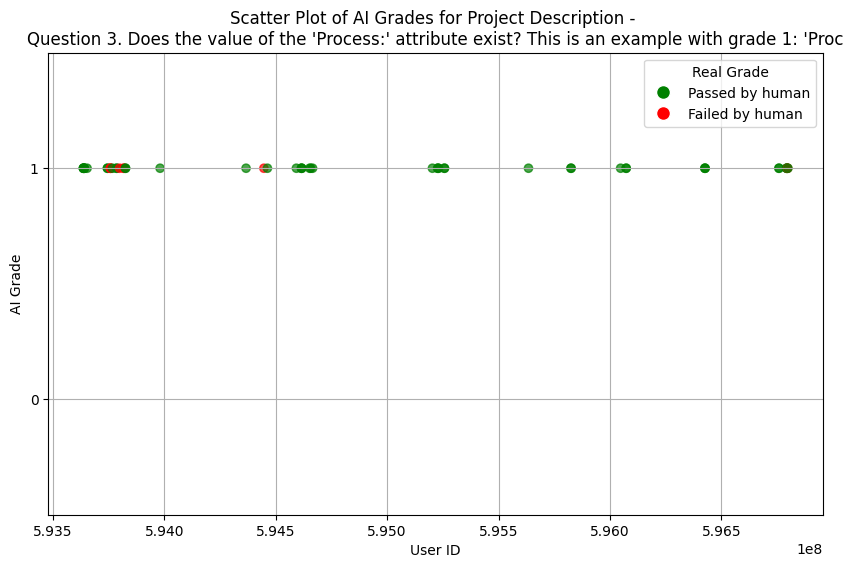

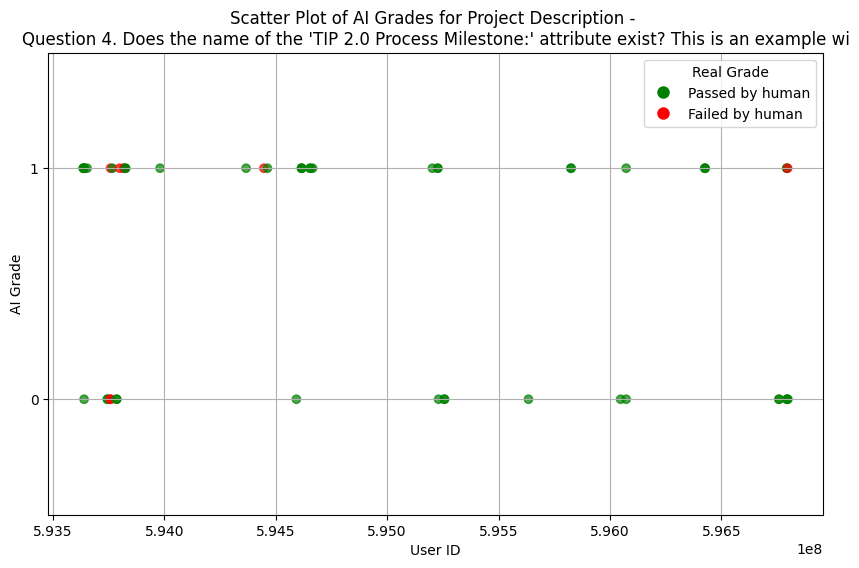

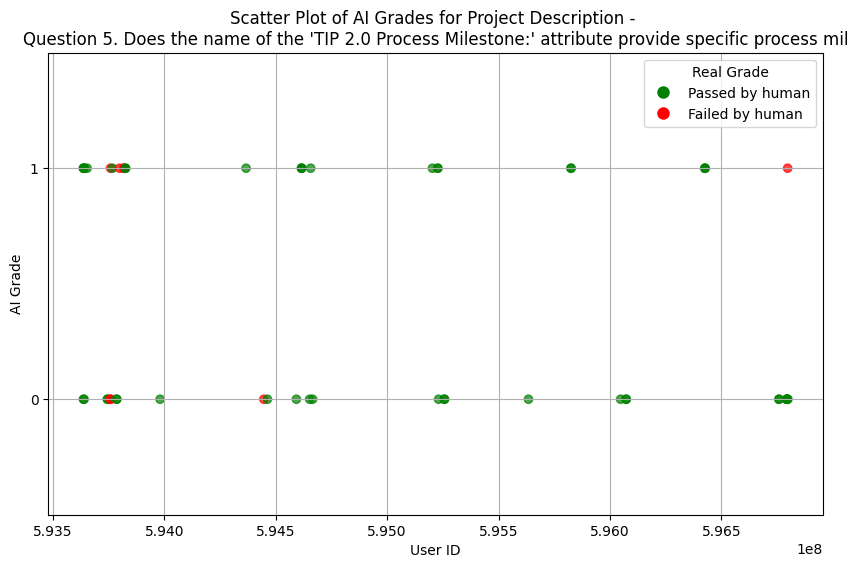

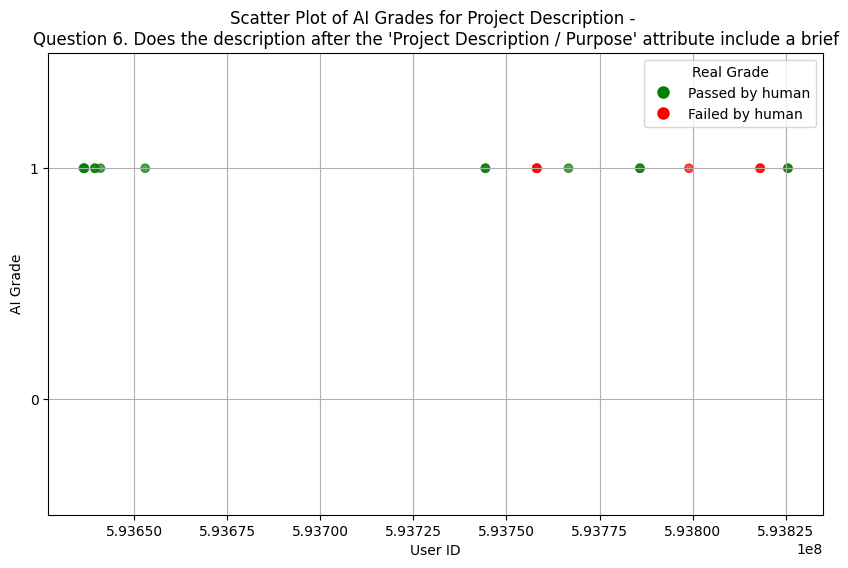

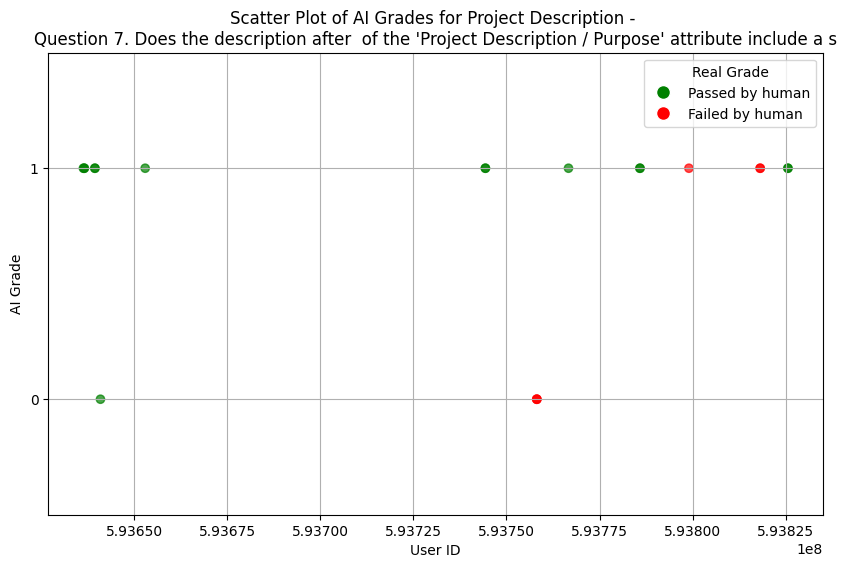

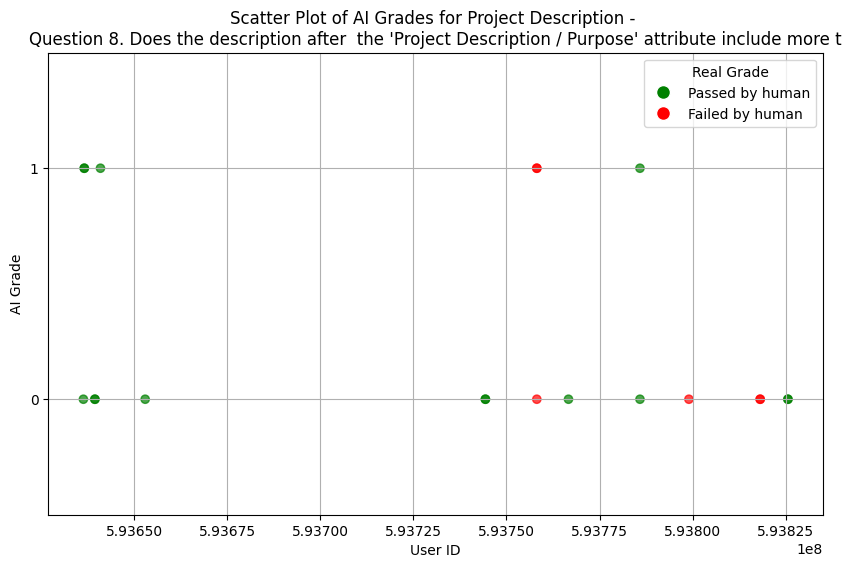

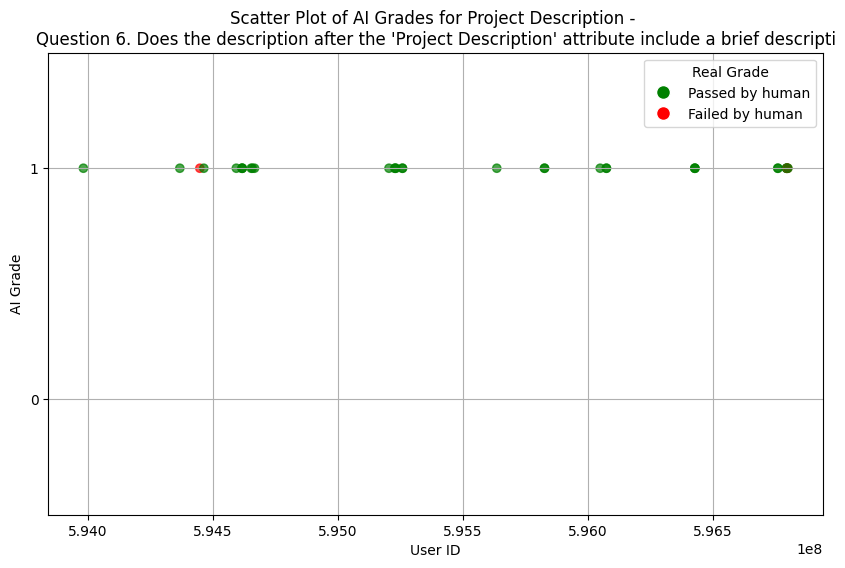

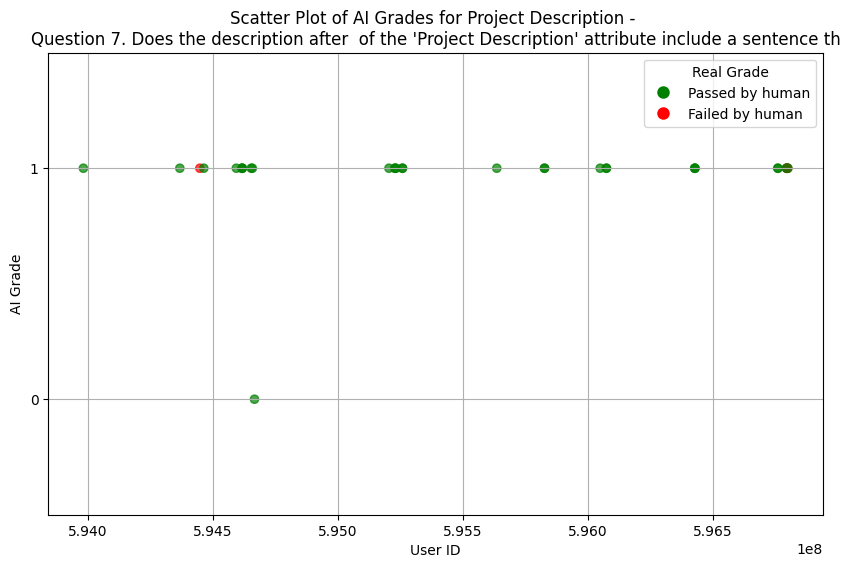

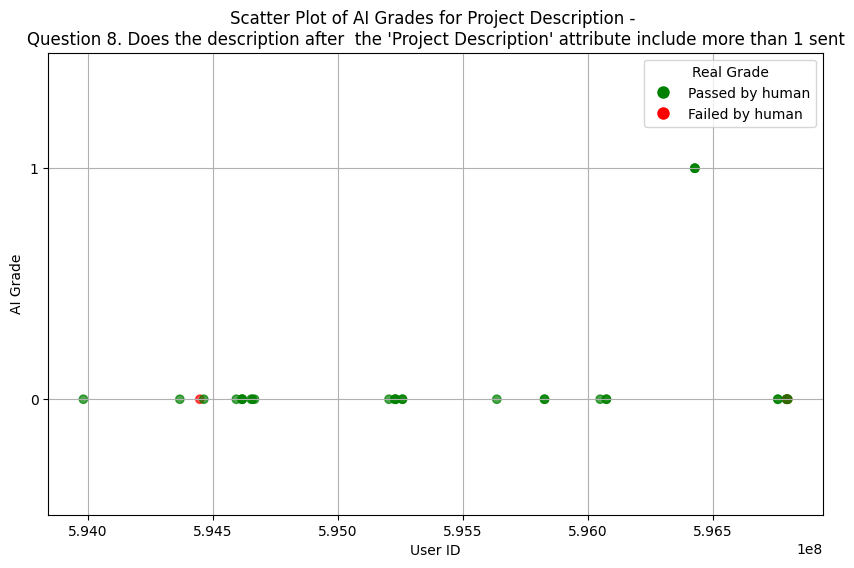

In [154]:
# Example usage
test_url = 'test_results/test_result_on_54_files_description_only_v4.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
plot_section_criteria_scatter(test_url,real_url,'Project Description')

In [155]:
test_url = 'test_results/test_result_on_54_files_description_only_v4.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.check_grades('Project Description')

Number of unique file:  54


In [156]:
visualizer.plot_failed_submissions('Project Description')

Number of file:  0


In [157]:
ver4 = pd.read_csv('test_results/test_result_on_54_files_description_only_v4.csv')
ver4

,Unnamed: 0,File_Name,AI_Grade,Comment,Section,Criteria
0,1,593636371,1,The value of the 'Project Name:' attribute exi...,Project Description / Purpose,Question 1. Is there any value of 'Project Nam...
1,2,593636371,1,The value of the 'Clinic:' attribute exists an...,Project Description / Purpose,Question 2. Does the value of the 'Clinic:' at...
2,3,593636371,1,The value of the 'Process:' attribute exists a...,Project Description / Purpose,Question 3. Does the value of the 'Process:' a...
3,4,593636371,1,The name of the 'TIP 2.0 Process Milestone:' a...,Project Description / Purpose,Question 4. Does the name of the 'TIP 2.0 Proc...
4,5,593636371,0,The name of the 'TIP 2.0 Process Milestone:' a...,Project Description / Purpose,Question 5. Does the name of the 'TIP 2.0 Proc...
...,...,...,...,...,...,...
427,4,596799191,0,Although the 'TIP 2.0 Process Milestone:' attr...,Project Description / Purpose,Question 4. Does the name of the 'TIP 2.0 Proc...
428,5,596799191,0,The 'TIP 2.0 Process Milestone:' attribute doe...,Project Description / Purpose,Question 5. Does the name of the 'TIP 2.0 Proc...
429,6,596799191,1,The description after the 'Project Description...,Project Description / Purpose,Question 6. Does the description after the 'Pr...
430,7,596799191,1,The description after the 'Project Description...,Project Description / Purpose,Question 7. Does the description after of the...


In [158]:
ver4['AI_Grade'].unique()

array([1, 0], dtype=int64)

# Visualize version 5

Number of files: 55


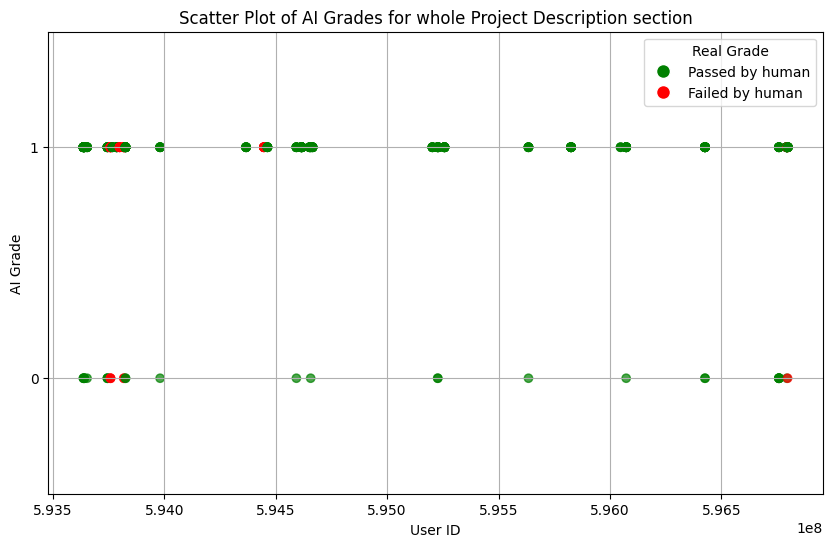

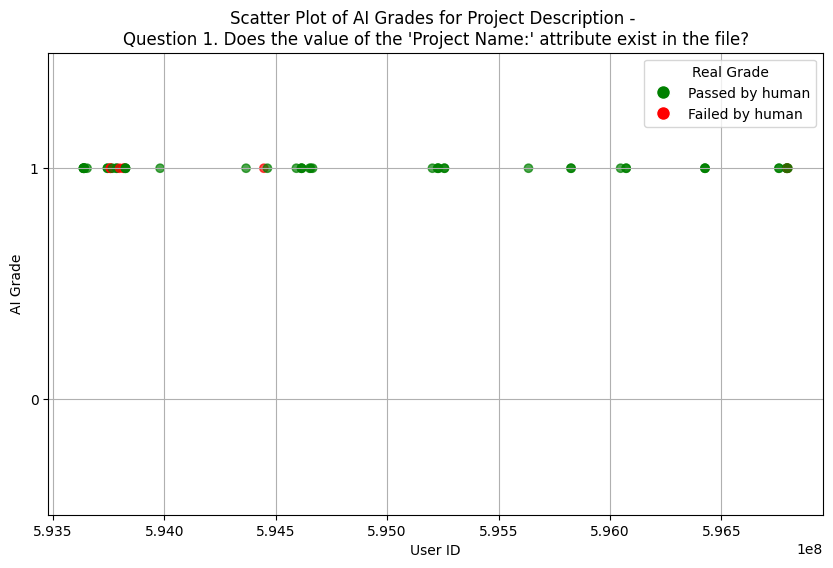

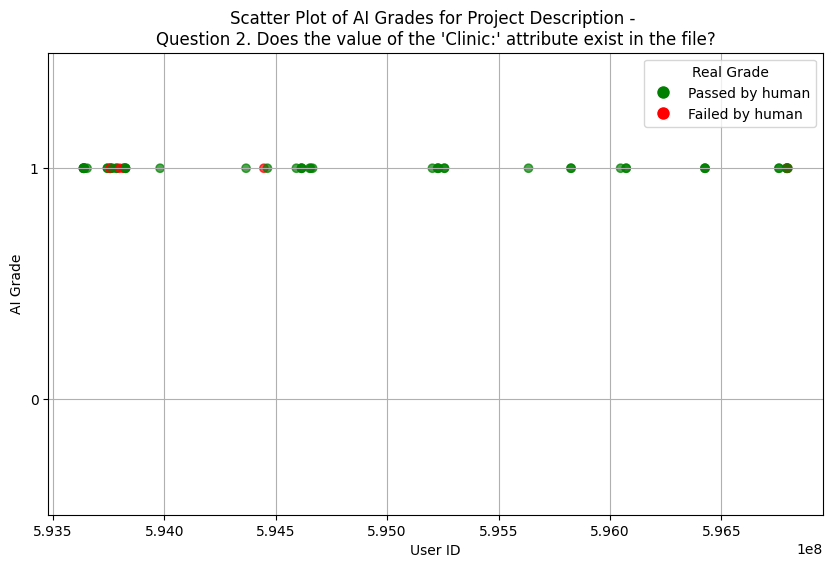

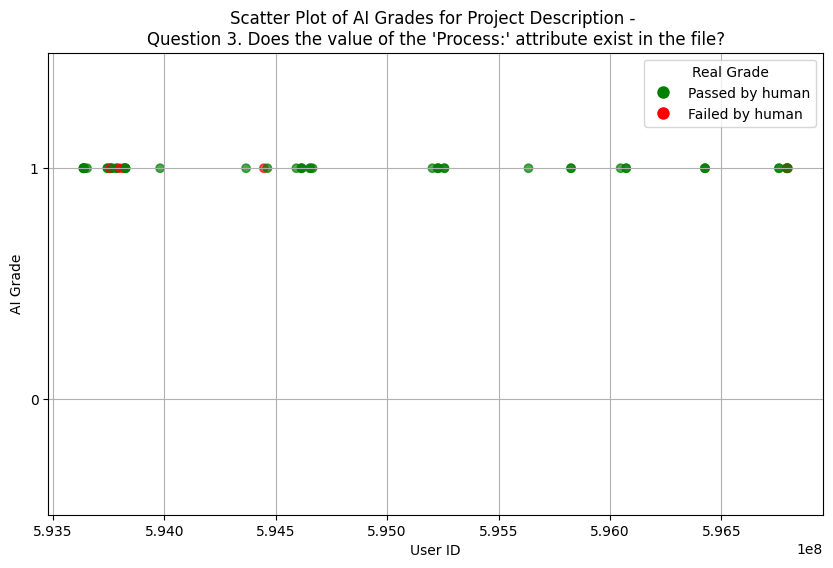

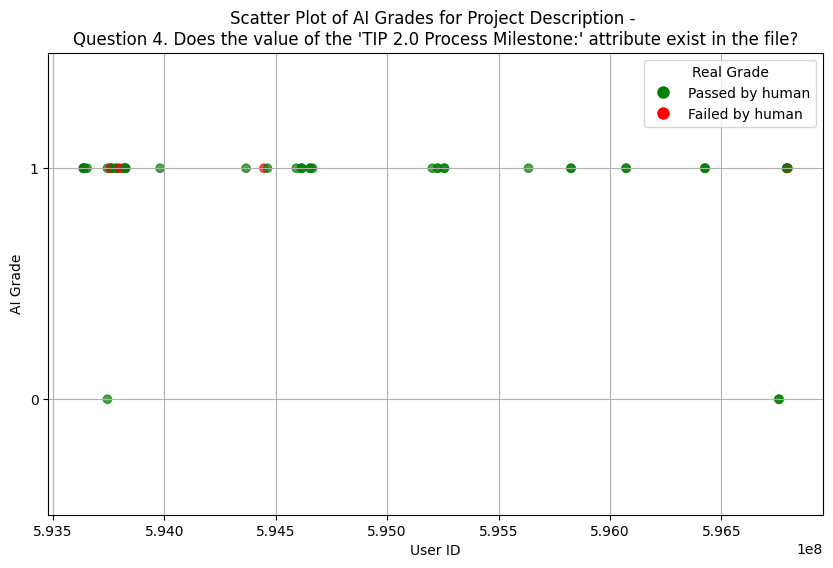

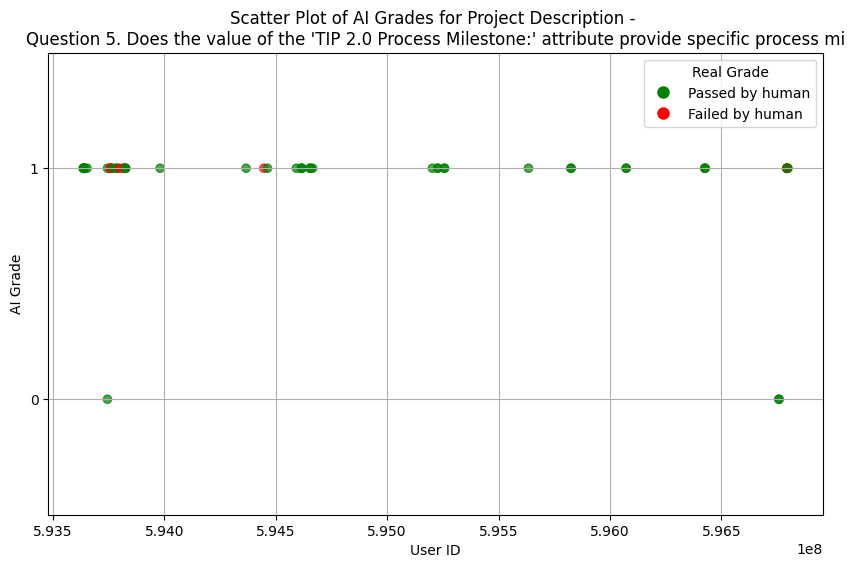

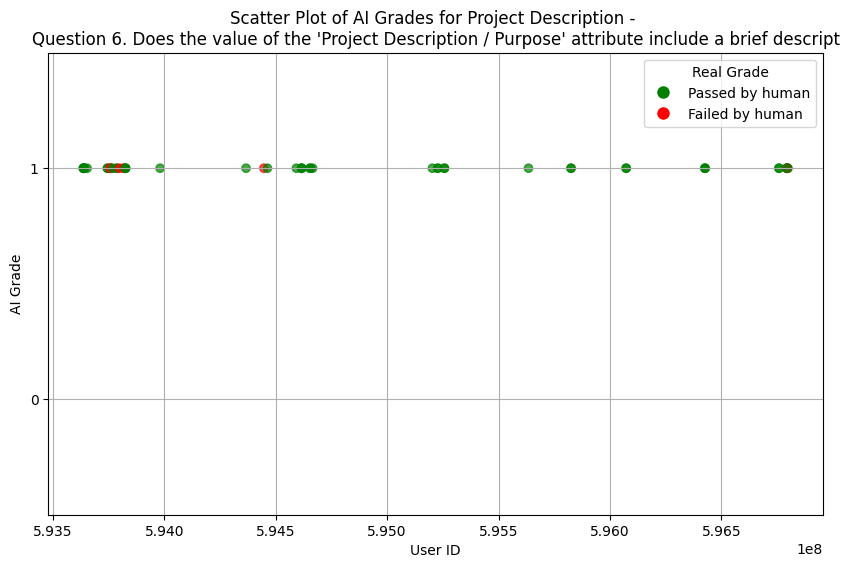

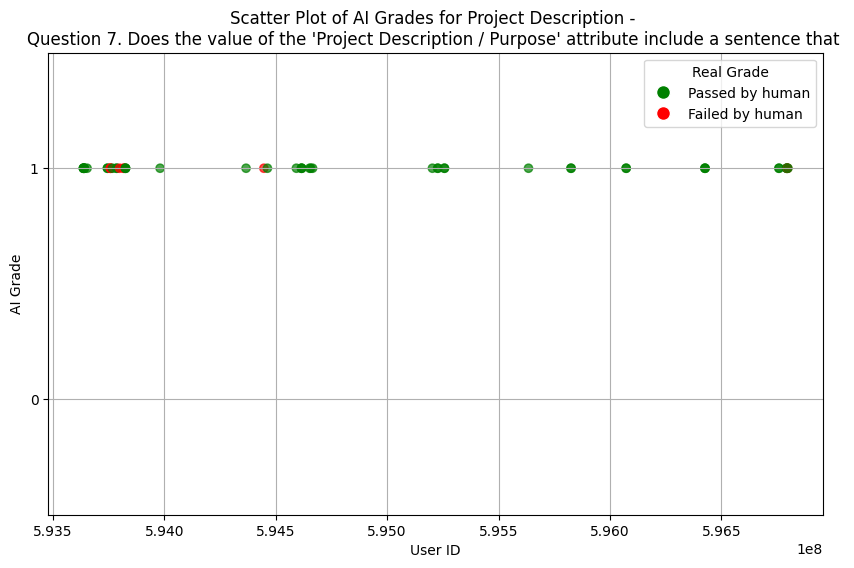

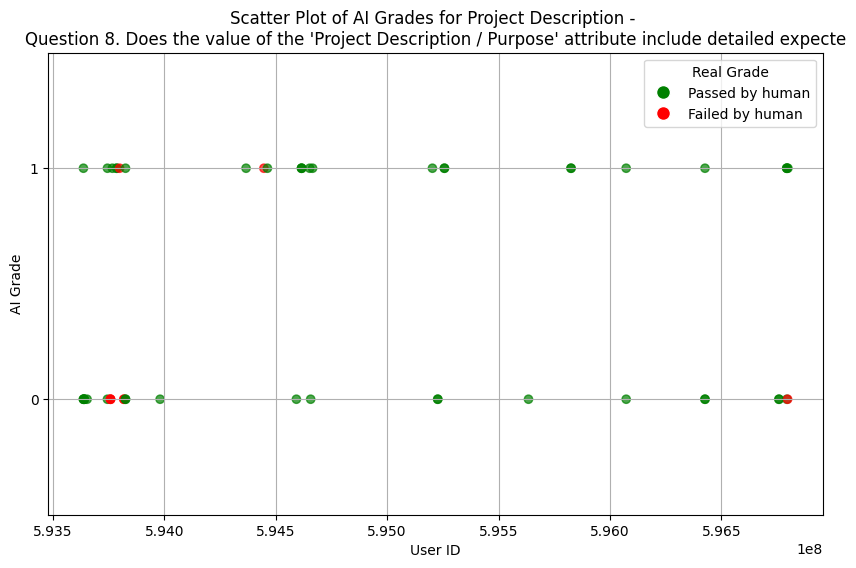

In [159]:
# Example usage
test_url = 'test_results/test_result_on_55_files_v5.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
plot_section_criteria_scatter(test_url,real_url,'Project Description')

In [160]:
test_url = 'test_results/test_result_on_55_files_v5.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_failed_submissions('Project Description')

Number of unique file:  55
Number of file:  53
----------------------------------------
user id: 593758154
Human Grade: 0.0
Human Comment: I see a somewhat clear project description and purpose statement with some detail. I recommend more background detail and a clear purpose statement like "The purpose of this project is to implement the PRAPARE screening tool". 

Section: Project Description
Criteria: Question 1. Does the value of the 'Project Name:' attribute exist in the file?
AI Grade: 1
AI Comment: There is a valid value for 'Project Name:' in the input.

Section: Project Description
Criteria: Question 2. Does the value of the 'Clinic:' attribute exist in the file?
AI Grade: 1
AI Comment: There is a valid value for 'Clinic:' in the input.

Section: Project Description
Criteria: Question 3. Does the value of the 'Process:' attribute exist in the file?
AI Grade: 1
AI Comment: There is a valid value for 'Process:' in the input.

Section: Project Description
Criteria: Question 4. Doe

# Version 6

In [161]:
test_url = 'test_results/test_result_on_55_files_v6.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_failed_submissions('Project Description')

Number of unique file:  55
Number of file:  54
----------------------------------------
user id: 593758154
Human Grade: 0.0
Human Comment: I see a somewhat clear project description and purpose statement with some detail. I recommend more background detail and a clear purpose statement like "The purpose of this project is to implement the PRAPARE screening tool". 

Section: Project Description
Criteria: Question 1. Is the Project Name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project Name is provided and enough to describe the project.

Section: Project Description
Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name, The Guidance Center, is provided.

Section: Project Description
Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name, Utilizing the PRAPARE tool, is provided.

Section: Project Description
Criteria: Question 4. Is the TIP

# Version 7

In [162]:
test_url = 'test_results/test_result_on_55_files_v7.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Description')

Number of unique file:  55
Number of false positive:  1
----------------------------------------
user id: 594446674
Human Grade: 0.0
Human Comment: I do not see enough detail about the project description and purpose statement. I recommend a clear statement like "The purpose of this project is to implement a ...". 

Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name is clearly stated and enough to describe the project.

Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name is explicitly mentioned as 'Arbor Medical Partner practices'.

Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name is described as 'Distribution of screening tool, documentation of results, and closed loop referral process for needed concerns'.

Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?


question_list:  ['Question 1. Is the Project name exist and enough to describe the project?'
 'Question 2. Is the Clinic name exist and tell the clinic names?'
 'Question 3. Is the Process name exist and tell the process names?'
 'Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?'
 'Question 5. Is TIP 2.0 milestone details the project milestone?'
 'Question 6. Is the project description /purpose includes a brief description of the project?'
 'Question 7. Is the project description /purpose includes a sentence explicitly stating the purpose of the project?'
 'Question 8. Is the project description /purpose includes detailed expected results from the project?']


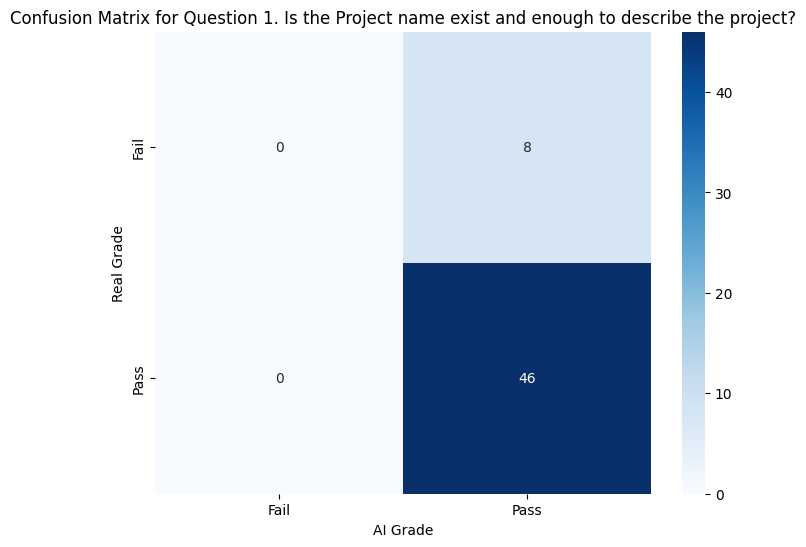

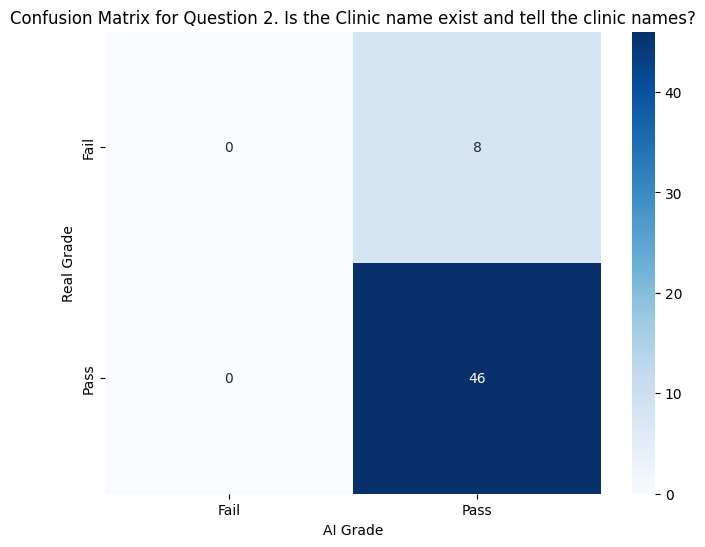

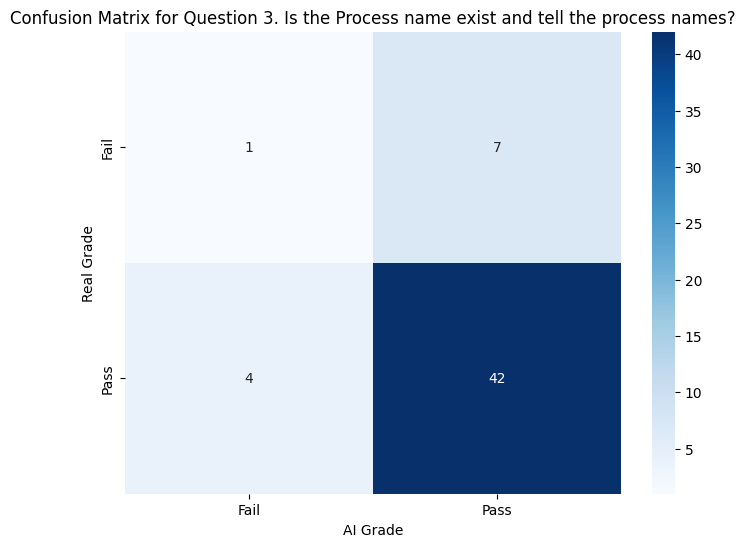

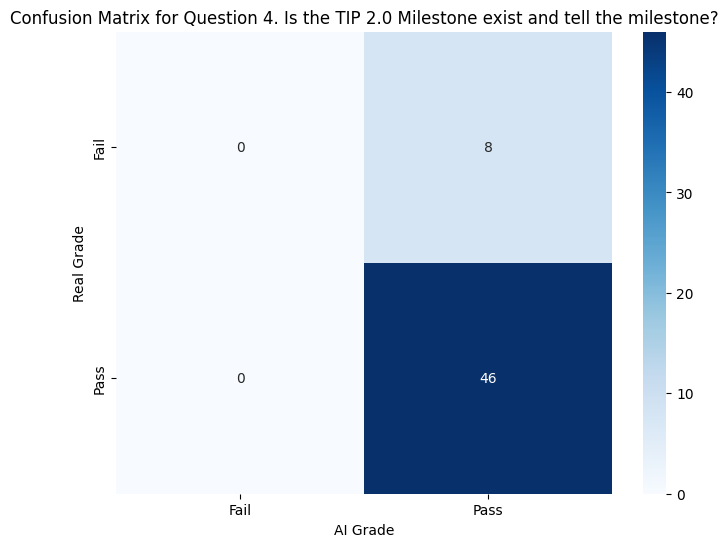

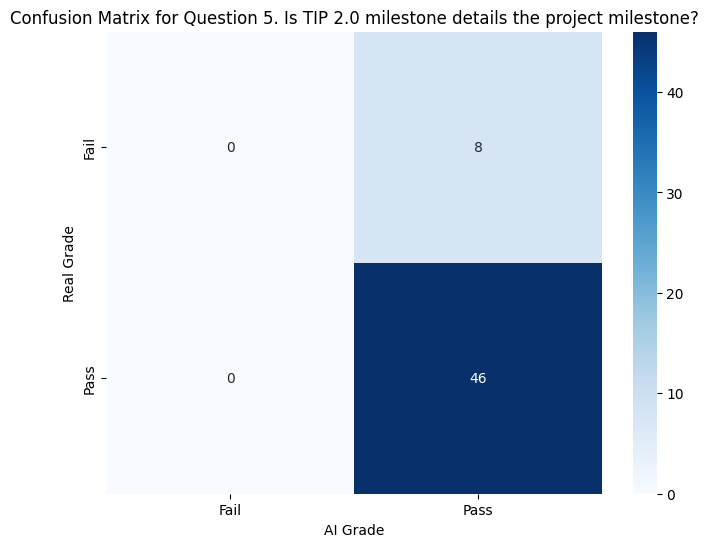

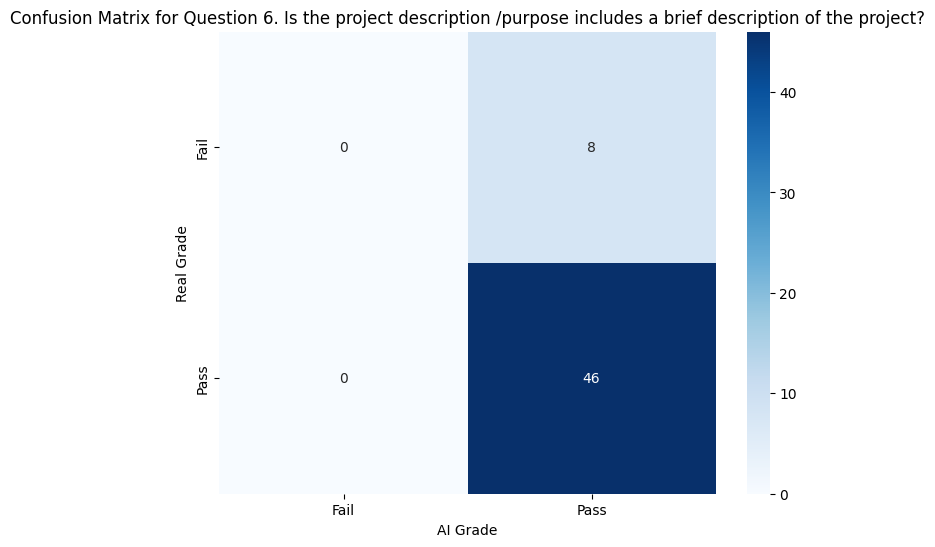

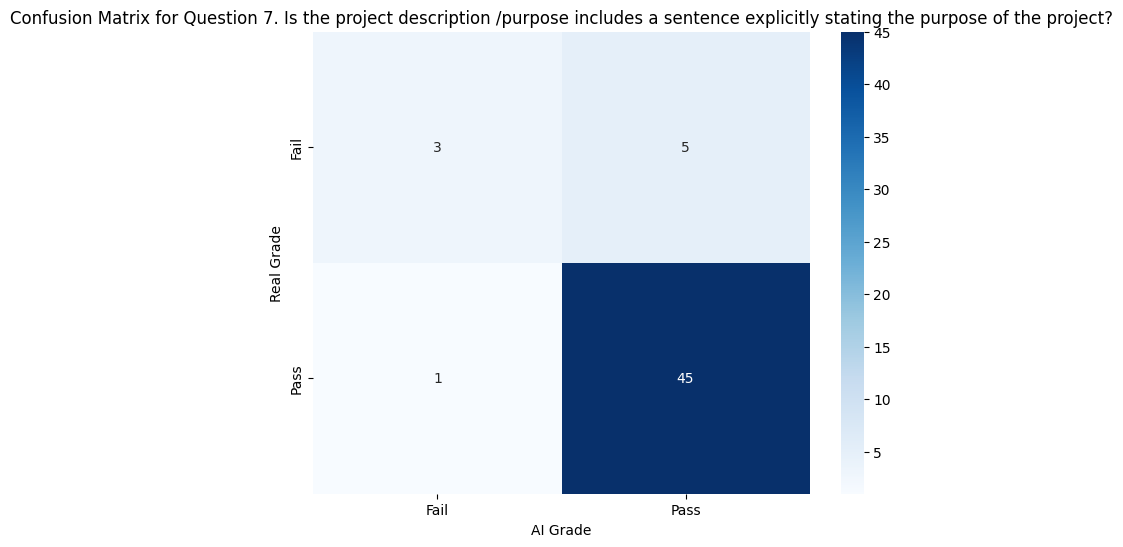

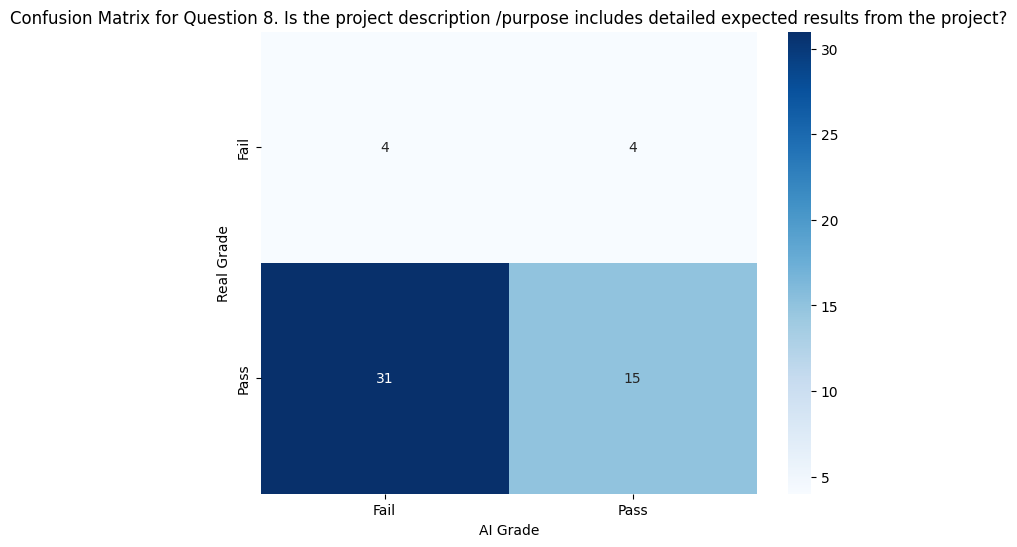

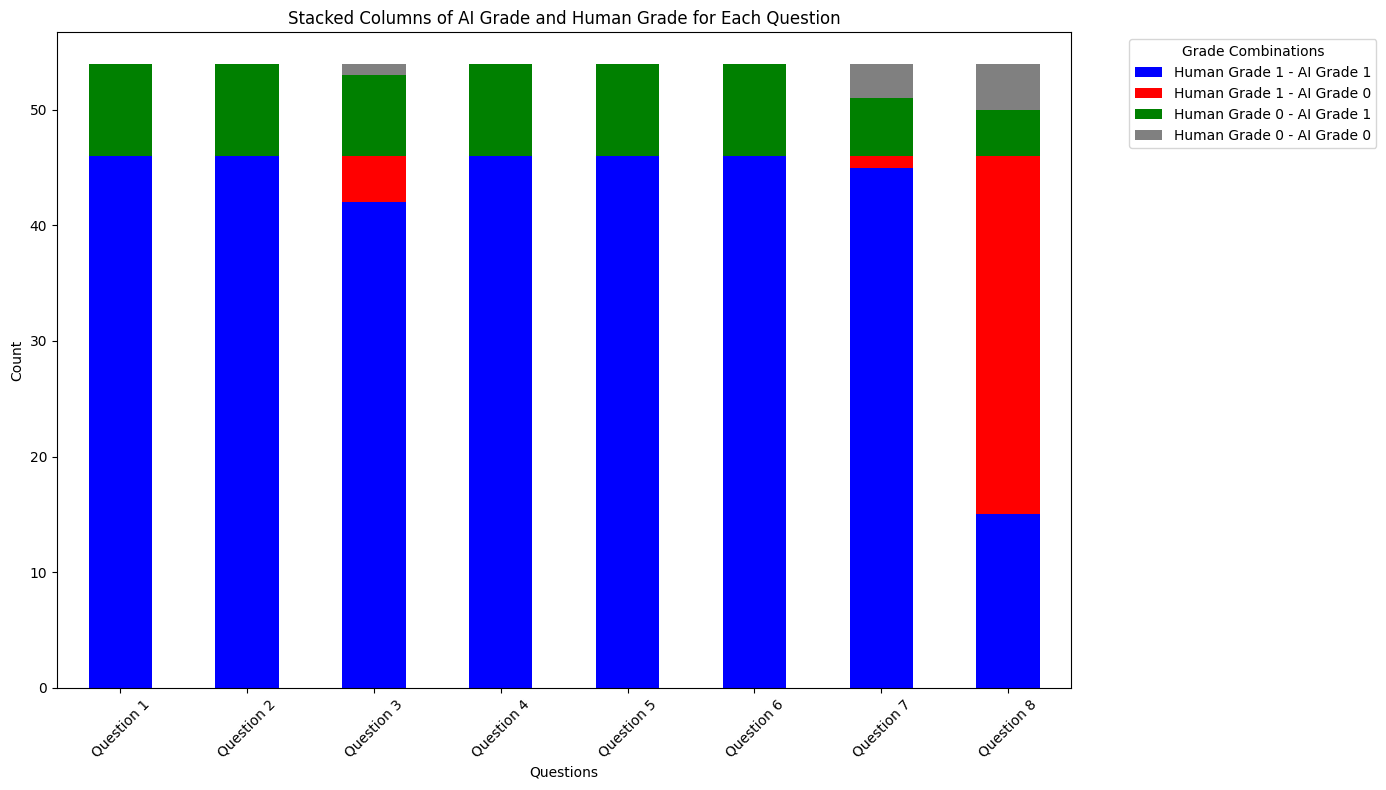

In [163]:
visualizer.plot_confusion_matrix_by_question('Project Description')

In [164]:
visualizer.merged_df

,Unnamed: 0,user_id,AI_Grade,Comment,Section,Criteria,Real_Grade,grader_name,grader_comment
0,1,593636371,1,The Project name is clearly stated and enough ...,Project Description,Question 1. Is the Project name exist and enou...,1.0,Kailey Love,I see a clear project description and purpose ...
1,2,593636371,1,"The Clinic name, EMPACT-Suicide Prevention Cen...",Project Description,Question 2. Is the Clinic name exist and tell ...,1.0,Kailey Love,I see a clear project description and purpose ...
2,3,593636371,1,"The Process name, Implementation of PRAPARE Sc...",Project Description,Question 3. Is the Process name exist and tell...,1.0,Kailey Love,I see a clear project description and purpose ...
3,4,593636371,1,"The TIP 2.0 Milestone, Adult BH. 1.C., is expl...",Project Description,Question 4. Is the TIP 2.0 Milestone exist and...,1.0,Kailey Love,I see a clear project description and purpose ...
4,5,593636371,1,"The TIP 2.0 milestone, Adult BH. 1.C., provide...",Project Description,Question 5. Is TIP 2.0 milestone details the p...,1.0,Kailey Love,I see a clear project description and purpose ...
...,...,...,...,...,...,...,...,...,...
427,4,596799191,1,The TIP 2.0 Milestone 'HRSN' is provided and t...,Project Description,Question 4. Is the TIP 2.0 Milestone exist and...,1.0,Samantha Basch,I see aim/purpose statements for the project. ...
428,5,596799191,1,The TIP 2.0 milestone details the project mile...,Project Description,Question 5. Is TIP 2.0 milestone details the p...,1.0,Samantha Basch,I see aim/purpose statements for the project. ...
429,6,596799191,1,The project description includes a brief descr...,Project Description,Question 6. Is the project description /purpos...,1.0,Samantha Basch,I see aim/purpose statements for the project. ...
430,7,596799191,1,The project description explicitly states the ...,Project Description,Question 7. Is the project description /purpos...,1.0,Samantha Basch,I see aim/purpose statements for the project. ...


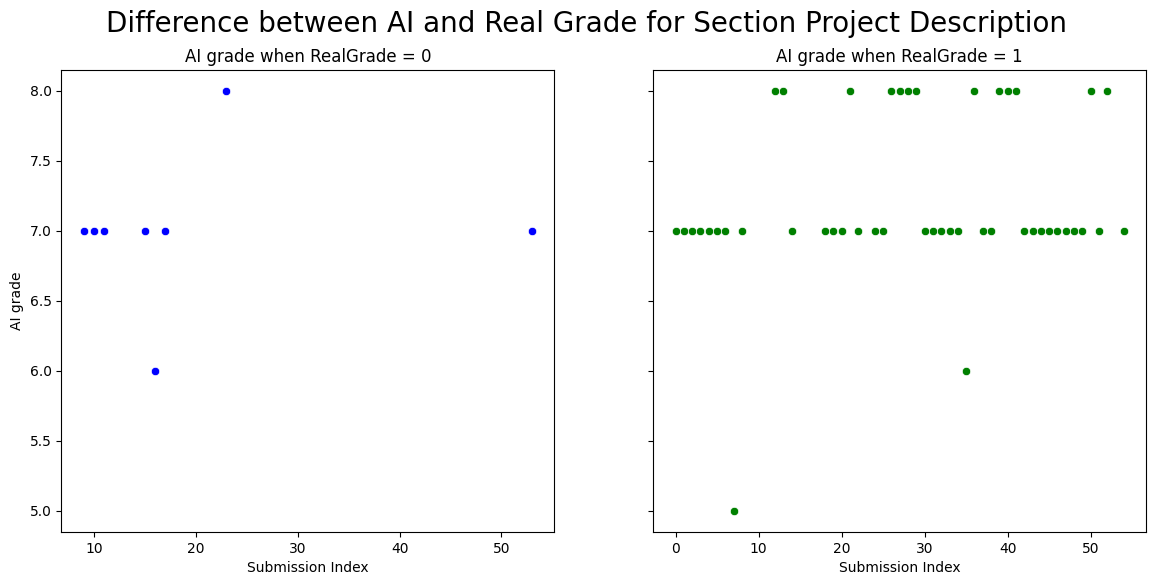

In [165]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

# Version 8

In [166]:
test_url = 'test_results/test_result_on_55_files_v8.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Description')

Number of unique file:  54
Number of false positive:  5
----------------------------------------
user id: 593758154
Human Grade: 0.0
Human Comment: I see a somewhat clear project description and purpose statement with some detail. I recommend more background detail and a clear purpose statement like "The purpose of this project is to implement the PRAPARE screening tool". 

Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name is provided and enough to describe the project.

Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name is provided, which is 'The Guidance Center'.

Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name is provided, which is 'Utilizing the PRAPARE tool'.

Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?
AI Grade: 1
AI Comment: The TIP 2.0 Milest

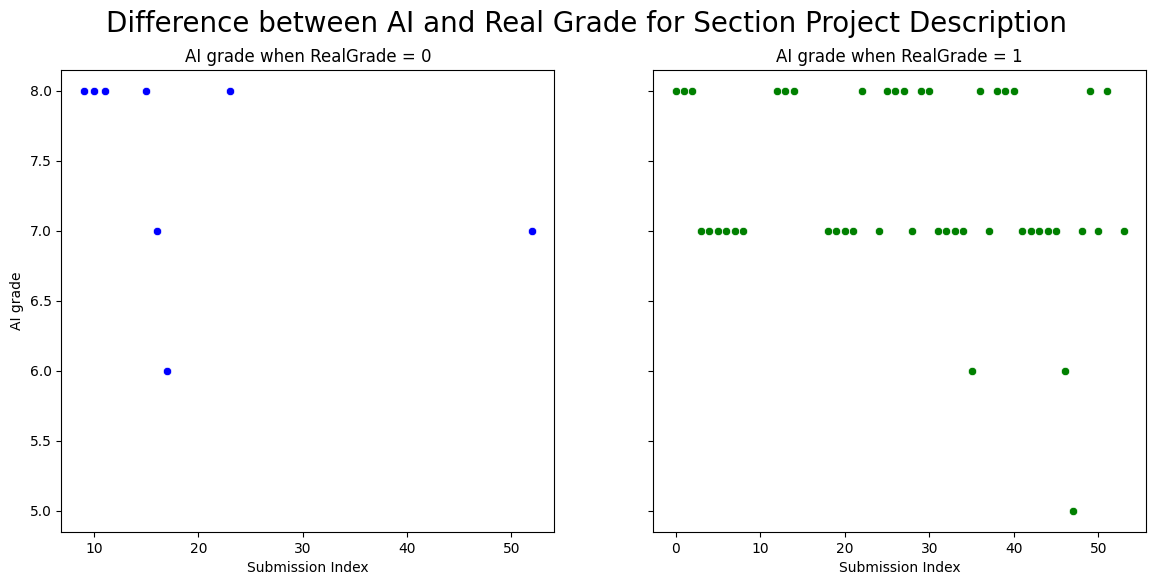

In [167]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

# Version 9

In [168]:
test_url = 'test_results/test_result_on_55_files_v9.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Description')

Number of unique file:  54
Number of false positive:  2
----------------------------------------
user id: 593799010
Human Grade: 0.0
Human Comment: I see a clear project description and purpose statement with enough detail. I recommend clarifying if dental varnish is currently or has been offered in the past. 

Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name is provided and enough to describe the project.

Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name is provided, which is Pediatrics GPS DBA: Children’s Medical Center of Tucson.

Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name is provided, which is Application of Fluoride Varnish.

Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?
AI Grade: 1
AI Comment: The TIP 2.0 Milestone is provided, which is #

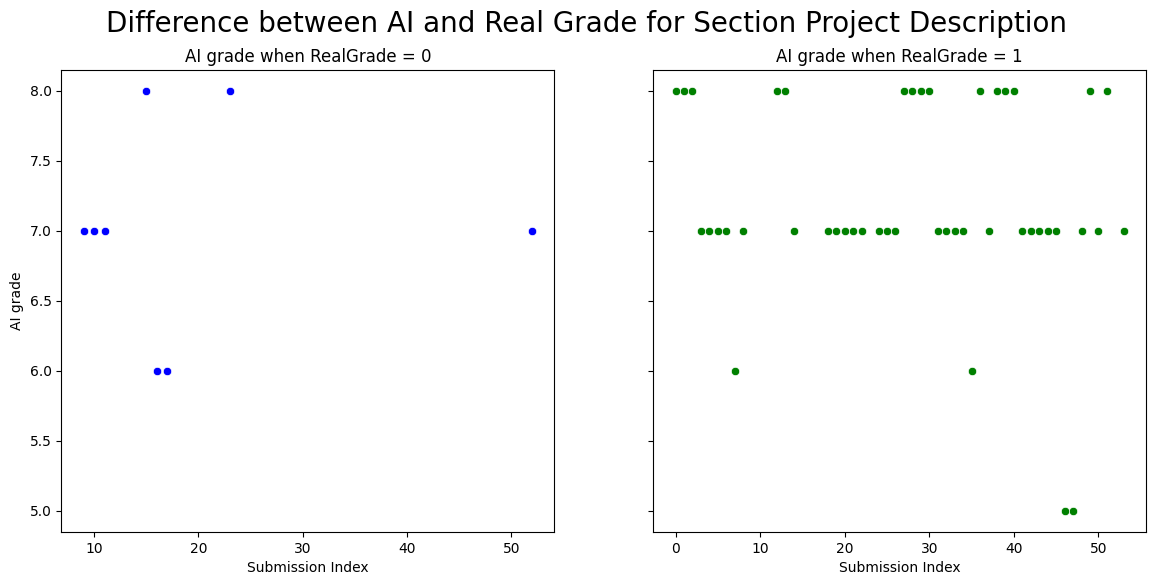

In [169]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

In [170]:
visualizer.plot_false_negative('Project Description')

Number of false positive:  31
----------------------------------------
user id: 593639464
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail. 

Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name 'MOMent of Care' is provided and enough to describe the project.

Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name 'All Denova Clinics' is provided.

Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name 'Standardizing screening for postpartum depression & anxiety' is provided.

Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?
AI Grade: 1
AI Comment: TIP 2.0 milestone 'Adult PCP: Identifying and engaging caregiver(s) and guardian(s) of a newborn to screen for anxiety and depression and coordinate with appropriate 

# Version 10

In [171]:
test_url = 'test_results/test_result_on_55_files_v9.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Description')

Number of unique file:  54
Number of false positive:  2
----------------------------------------
user id: 593799010
Human Grade: 0.0
Human Comment: I see a clear project description and purpose statement with enough detail. I recommend clarifying if dental varnish is currently or has been offered in the past. 

Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name is provided and enough to describe the project.

Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name is provided, which is Pediatrics GPS DBA: Children’s Medical Center of Tucson.

Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name is provided, which is Application of Fluoride Varnish.

Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?
AI Grade: 1
AI Comment: The TIP 2.0 Milestone is provided, which is #

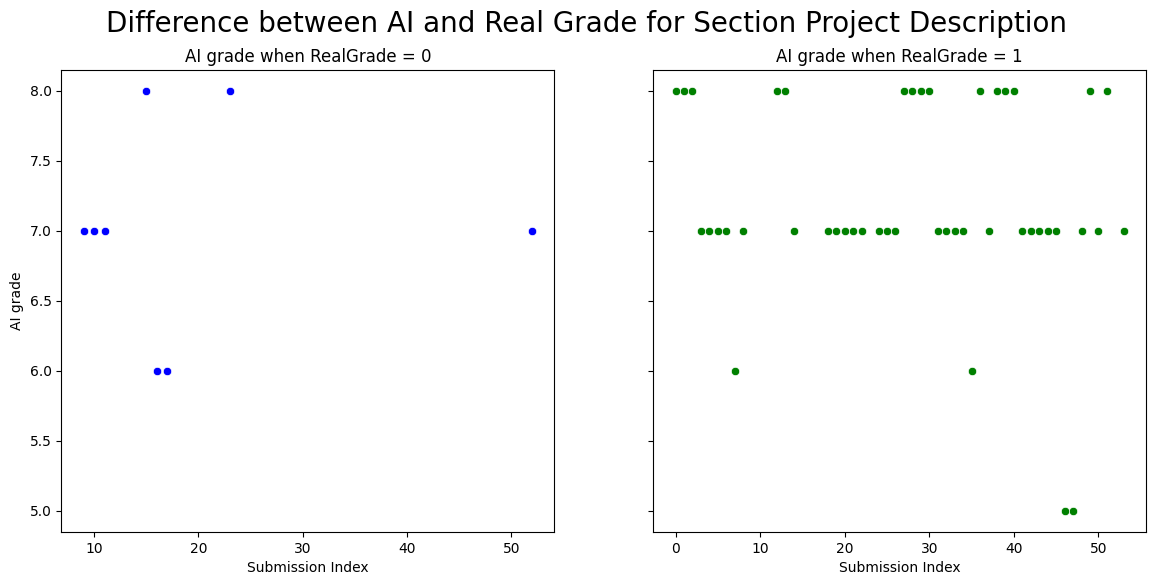

In [172]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

In [173]:
visualizer.plot_false_negative('Project Description')

Number of false positive:  31
----------------------------------------
user id: 593639464
Human Grade: 1.0
Human Comment: I see a clear project description and purpose statement with enough detail. 

Criteria: Question 1. Is the Project name exist and enough to describe the project?
AI Grade: 1
AI Comment: The Project name 'MOMent of Care' is provided and enough to describe the project.

Criteria: Question 2. Is the Clinic name exist and tell the clinic names?
AI Grade: 1
AI Comment: The Clinic name 'All Denova Clinics' is provided.

Criteria: Question 3. Is the Process name exist and tell the process names?
AI Grade: 1
AI Comment: The Process name 'Standardizing screening for postpartum depression & anxiety' is provided.

Criteria: Question 4. Is the TIP 2.0 Milestone exist and tell the milestone?
AI Grade: 1
AI Comment: TIP 2.0 milestone 'Adult PCP: Identifying and engaging caregiver(s) and guardian(s) of a newborn to screen for anxiety and depression and coordinate with appropriate 

# Version 7_9

In [174]:
test_url = 'test_results/test_result_on_56_files_v_7_9.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)

Number of unique file:  54


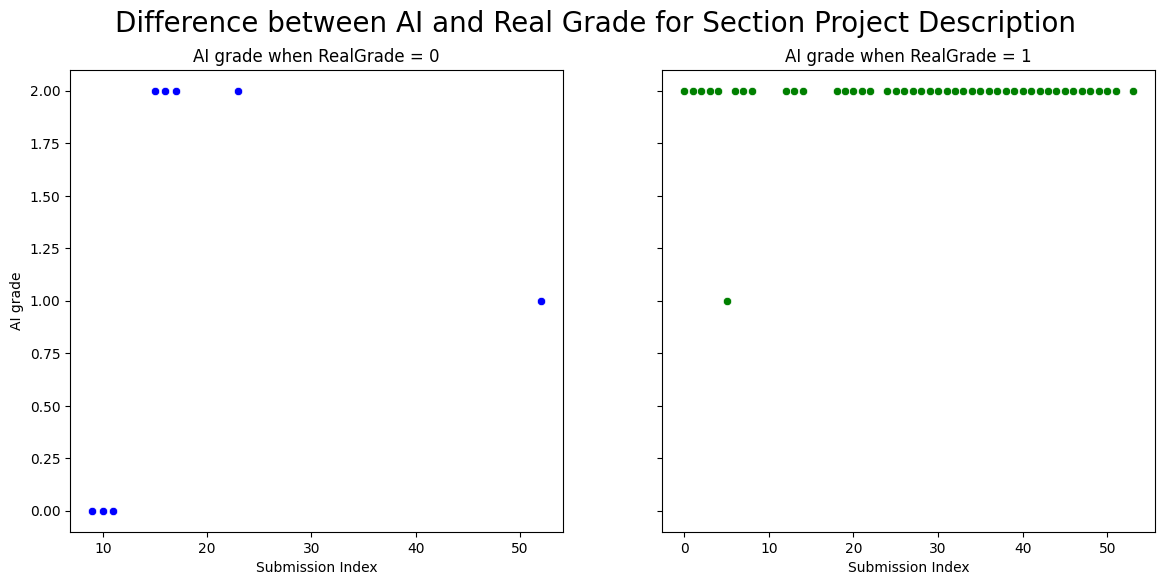

In [175]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

# Version 7_10

In [176]:
test_url = 'test_results/test_result_on_56_files_v_7_10.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)

Number of unique file:  54


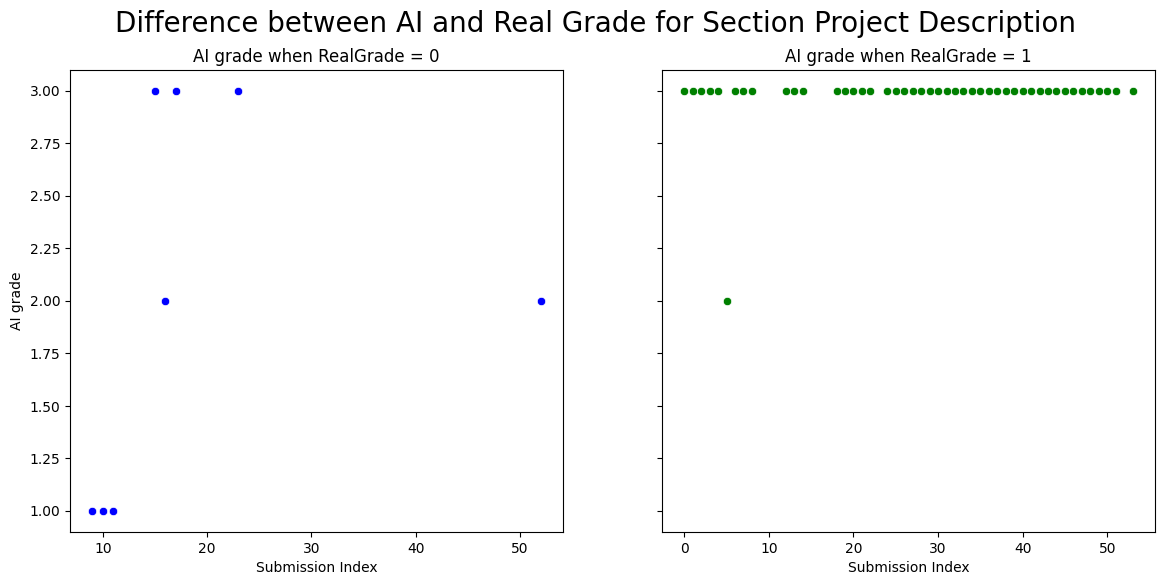

In [177]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

# Version 7_11

In [178]:
test_url = 'test_results/test_result_on_56_files_v_7_11.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)

Number of unique file:  54


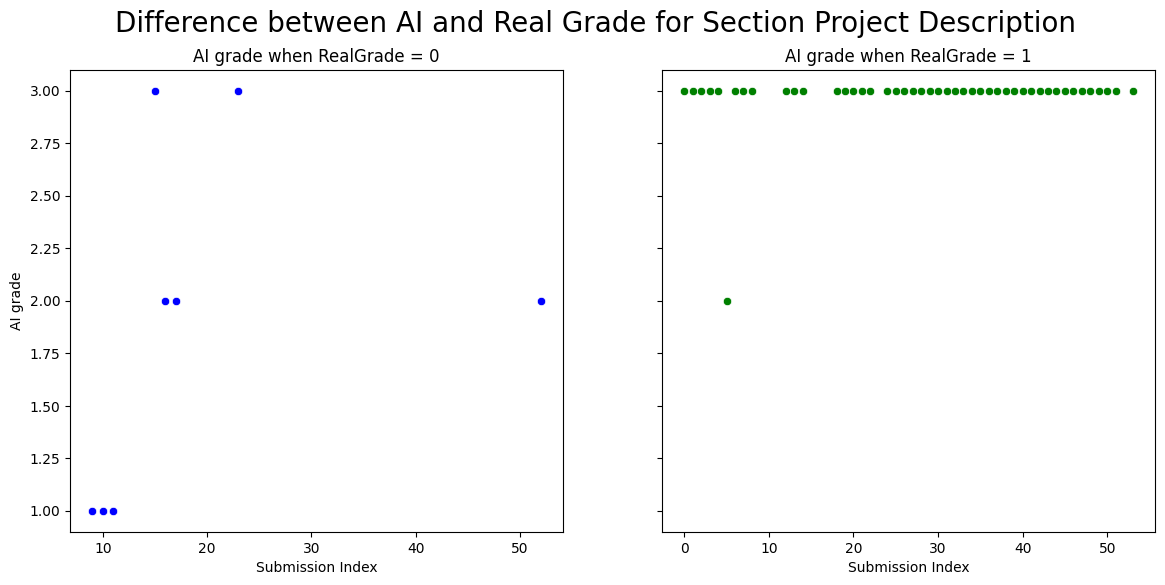

In [180]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

question_list:  []


IndexError: index 0 is out of bounds for axis 0 with size 0

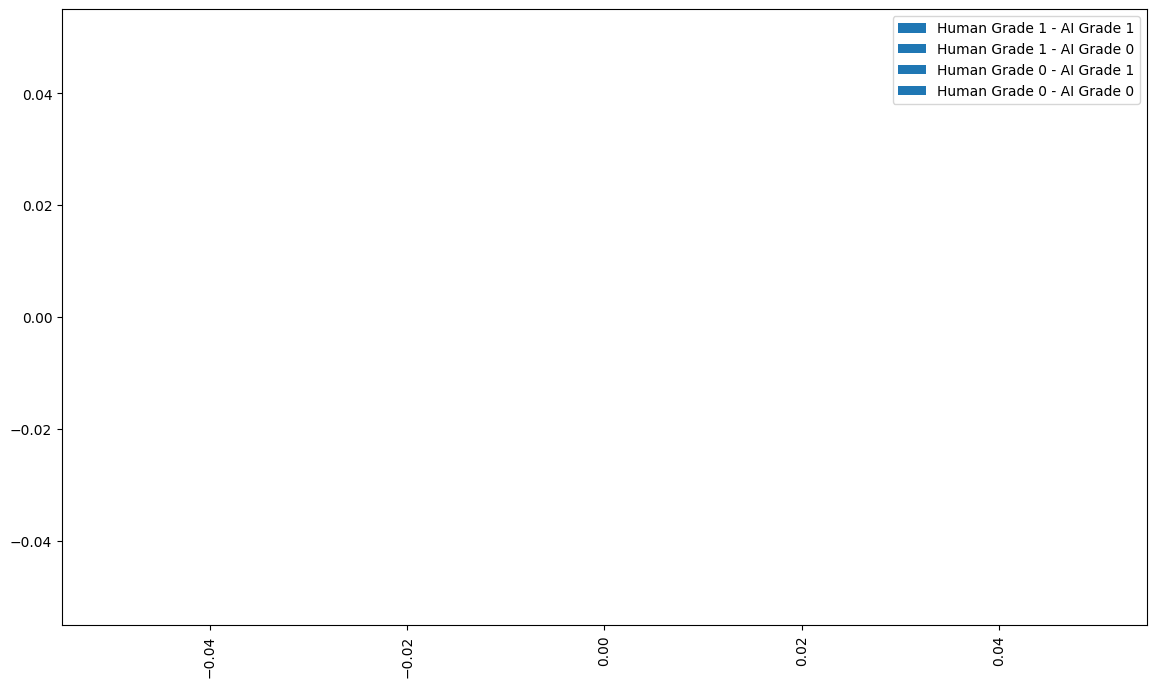

In [182]:
visualizer.plot_confusion_matrix_by_question('Project Description')

In [205]:
visualizer.merged_df

,Unnamed: 0,user_id,AI_Grade,Comment,Section,Criteria,Real_Grade,grader_name,grader_comment
0,1,593636371,1,Explicit purpose found: 'The purpose of this p...,Project Description,Question 7 - Does it include explicit purpose?,1.0,Kailey Love,I see a clear project description and purpose ...
1,1,593636611,1,Explicit purpose found: 'The purpose of this p...,Project Description,Question 7 - Does it include explicit purpose?,1.0,Phelene de Vries Stoutt,NaN
2,1,593636612,1,Explicit purpose found: 'The purpose of this p...,Project Description,Question 7 - Does it include explicit purpose?,1.0,Phelene de Vries Stoutt,I see a clear project description and purpose ...
3,1,593639464,1,Explicit purpose found: 'The MOMent of Care Pr...,Project Description,Question 7 - Does it include explicit purpose?,1.0,Samantha Basch,I see a clear project description and purpose ...
4,1,593639465,1,Explicit purpose found: 'The purpose of this p...,Project Description,Question 7 - Does it include explicit purpose?,1.0,Samantha Basch,I see a clear project description and purpose ...
...,...,...,...,...,...,...,...,...,...
157,1,596794231,1,Description found: background: 'HRSN screening...,Project Description,Question 6 - Does it include a brief descripti...,1.0,Samantha Basch,I see a clear project description and purpose ...
158,1,596794692,1,"Description found: background: 'At present, HR...",Project Description,Question 6 - Does it include a brief descripti...,1.0,Matt Martin,I see a clear project description and purpose ...
159,1,596794693,1,Description found: background: 'the HRSN scree...,Project Description,Question 6 - Does it include a brief descripti...,1.0,Matt Martin,I see a clear project description and purpose ...
160,1,596797800,1,Description found: background: 'Addressing soc...,Project Description,Question 6 - Does it include a brief descripti...,0.0,Matt Martin,I do not see enough detail about the project d...


# Version 7_11 100 files

In [183]:
test_url = 'test_results/test_result_on_100_files_v_7_11.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Description')

Number of unique file:  137
Number of false positive:  4
----------------------------------------
user id: 593799010
Human Grade: 0.0
Human Comment: I see a clear project description and purpose statement with enough detail. I recommend clarifying if dental varnish is currently or has been offered in the past. 

Criteria: Question 6 - Does it include a brief description of the project?
AI Grade: 1
AI Comment: Description found: background: 'Fluoride varnish application is used to prevent tooth decay and strengthen tooth enamel.'

Criteria: Question 7 - Does it include explicit purpose of the project?
AI Grade: 1
AI Comment: Explicit purpose found: 'The purpose of this project is to reduce dental caries and to promote oral health.'

Criteria: Question 8 - Does it include expected result?
AI Grade: 1
AI Comment: Expected results found: 'to reduce dental caries and to promote oral health. We anticipate that our patients will have improved engagement with their Dental Home and improved ora

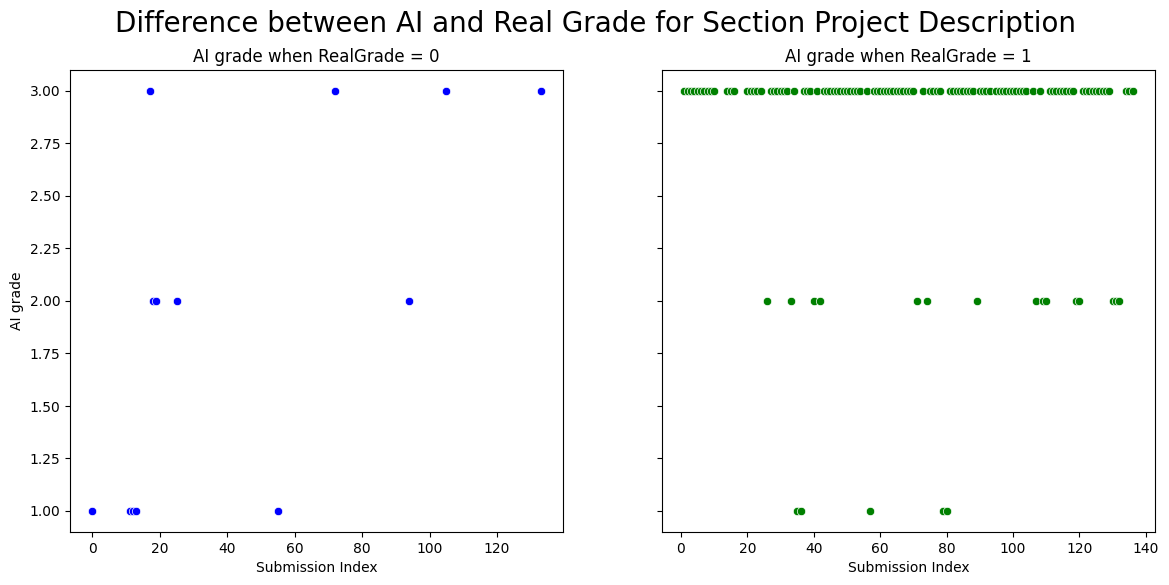

In [184]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Description')

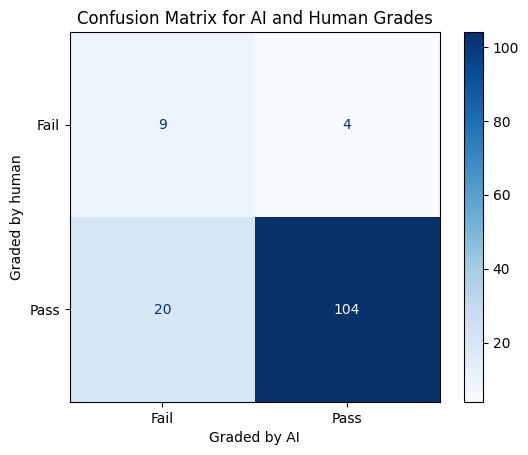

In [185]:
visualizer.plot_overall_confusion_matrix()

question_list:  ['Question 6 - Does it include a brief description of the project?'
 'Question 7 - Does it include explicit purpose of the project?'
 'Question 8 - Does it include expected result?']


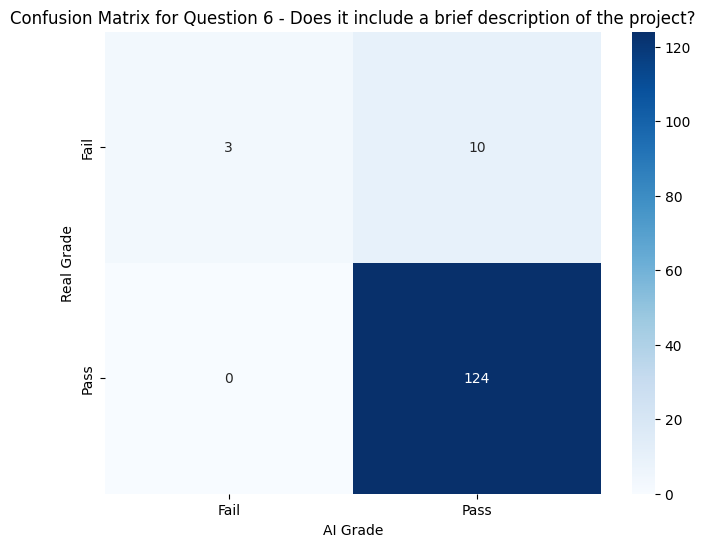

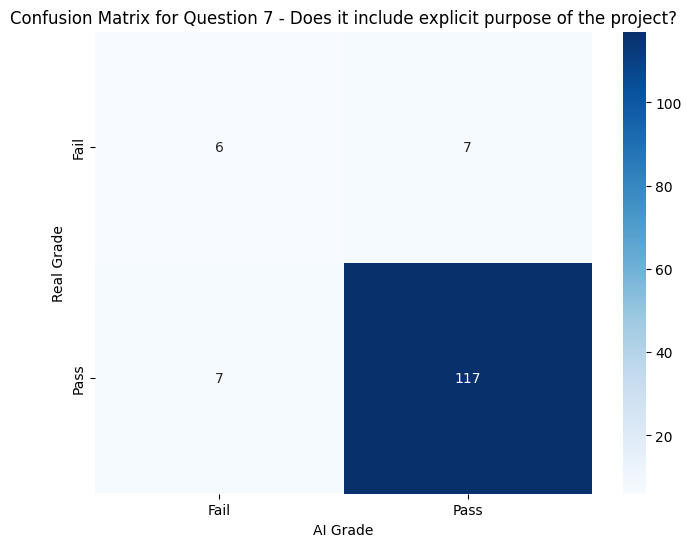

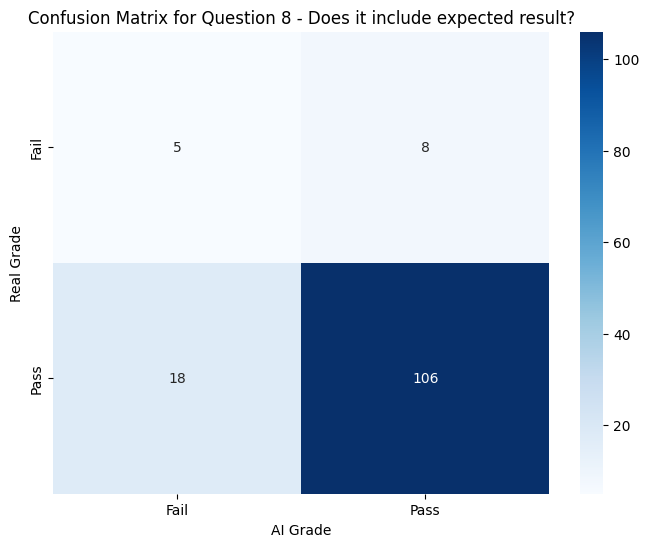

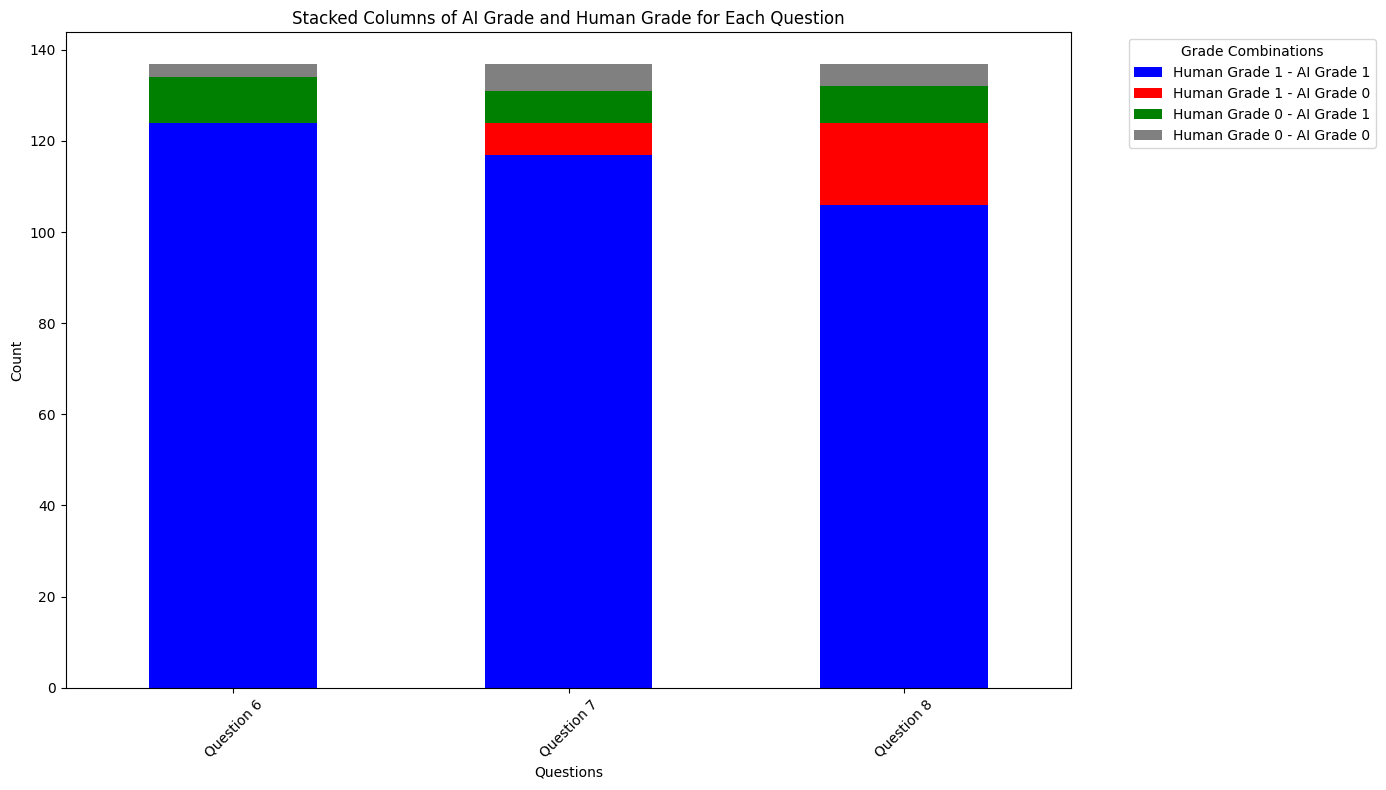

In [186]:
visualizer.plot_confusion_matrix_by_question('Project Description')

# Develop database for Description Scope Overview

In [202]:
grade_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'
grade_df = pd.read_csv(grade_url)
grade_df = grade_df[['user_id','score','description']]
grade_df

,user_id,score,description
0,593636370,1.0,Process Milestone
1,593636370,1.0,Project Description
2,593636370,1.0,Project Overview
3,593636370,1.0,Timeline
4,593636370,1.0,Project Scope
...,...,...,...
1075,604016476,1.0,Project Description
1076,604016476,1.0,Project Overview
1077,604016476,1.0,Timeline
1078,604016476,1.0,Project Scope


In [203]:
# Pivot the DataFrame
pivot_df = grade_df.pivot(index='user_id', columns='description', values='score')
# Calculate the total score for each user_id
pivot_df['Total_Score'] = pivot_df.sum(axis=1)

# Add the 'Pass' column based on the total score
pivot_df['Pass'] = pivot_df['Total_Score'].apply(lambda x: 1 if x >= 3 else 0)

# Replace 1 with "pass" and 0 with "fail" in all columns
pivot_df = pivot_df.replace({1: 'pass', 0: 'fail'})

# Reset the index to make 'user_id' a column again
pivot_df.reset_index(inplace=True)

# Display the resulting DataFrame
pivot_df

description,user_id,Process Milestone,Project Description,Project Overview,Project Scope,Project Team,Timeline,Total_Score,Pass
0,593634504,pass,fail,pass,pass,pass,fail,4.0,pass
1,593636370,pass,pass,pass,pass,pass,pass,6.0,pass
2,593636371,pass,pass,pass,pass,pass,pass,6.0,pass
3,593636611,pass,pass,pass,pass,pass,pass,6.0,pass
4,593636612,pass,pass,pass,pass,pass,pass,6.0,pass
...,...,...,...,...,...,...,...,...,...
175,606994851,fail,pass,pass,pass,pass,pass,5.0,pass
176,606999758,fail,pass,pass,pass,pass,pass,5.0,pass
177,607134601,pass,pass,pass,pass,pass,pass,6.0,pass
178,607134602,pass,pass,pass,pass,pass,pass,6.0,pass


In [204]:
pivot_df.to_csv('auto_grading_trainingset/Relationship_between_description_overview_scope_each_submission.csv', index=False)

# Visualize Project Overview - V1

In [209]:
test_url = 'test_results/test_result_prj_overview_100_files.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Overview')

Number of unique file:  132
Number of false positive:  0


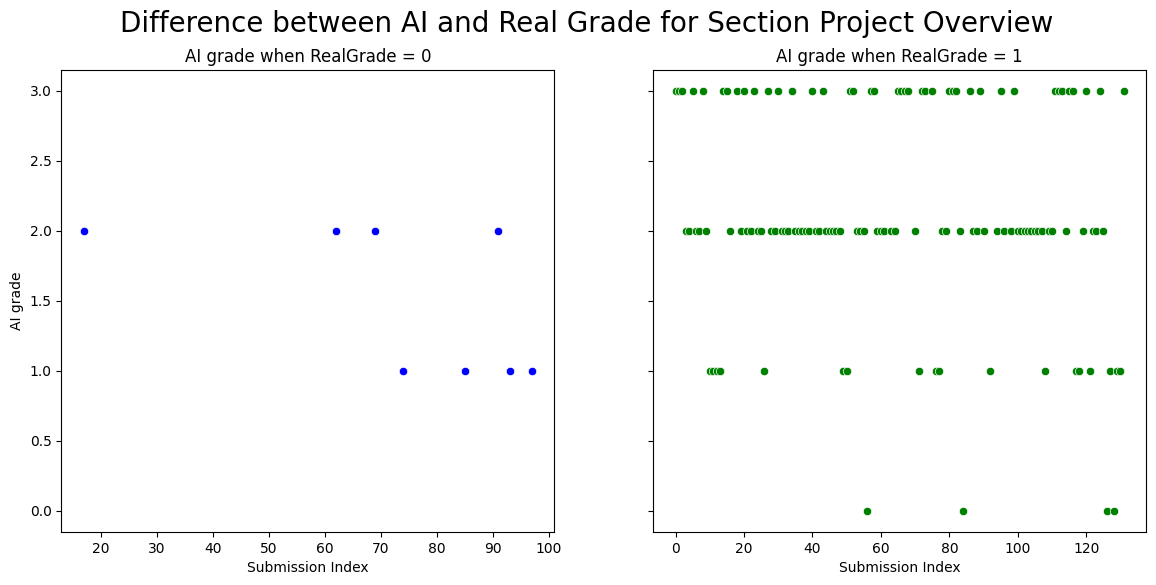

In [210]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Overview')

question_list:  ["Question 1. Does the value of the 'Problem Summary:' attribute include a detailed (at least 1 sentence) and logical problem statement?"
 "Question 2. Does the value of the 'Desired Outcome(s):' attribute include a at least 1 sentence explicitly talking about the expected results/desired outcomes?"
 "Question 3. Does the value of the 'Benefits:' attribute include a detailed (at least 1 sentence) explicitly talking about the benefits of this project?"]


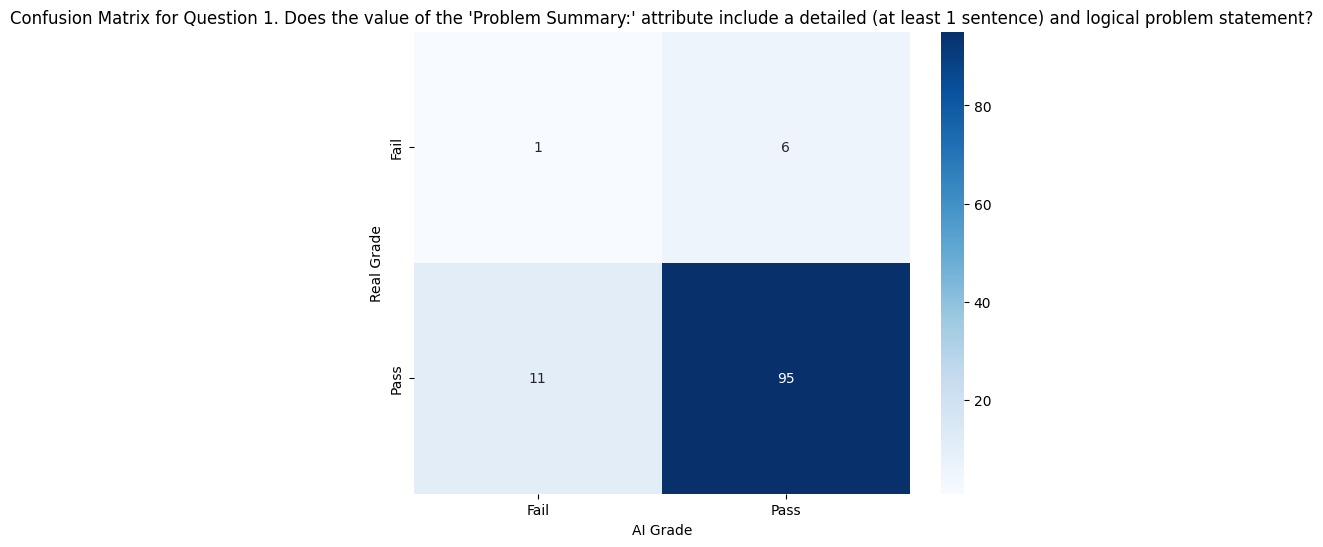

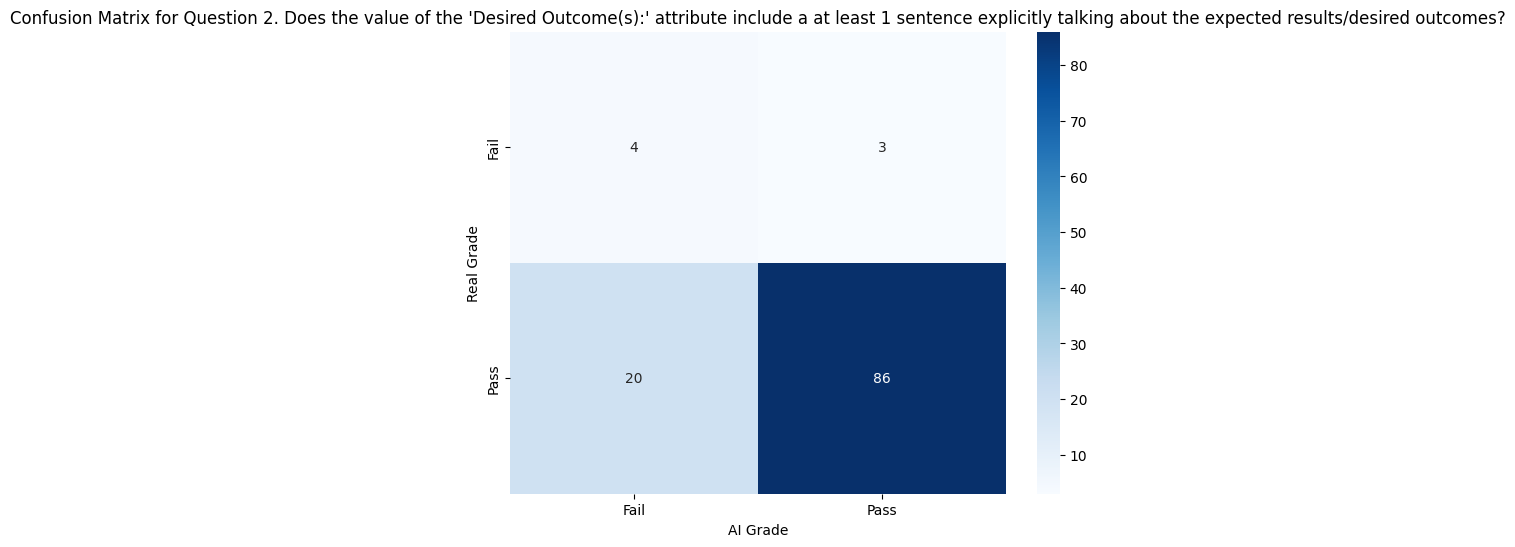

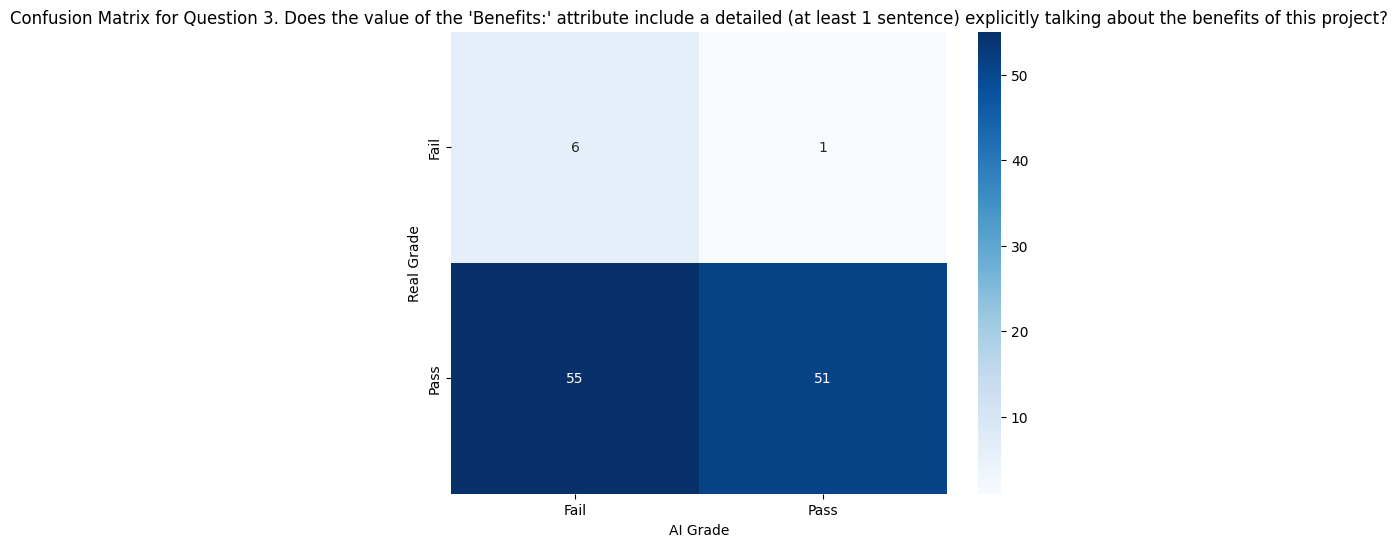

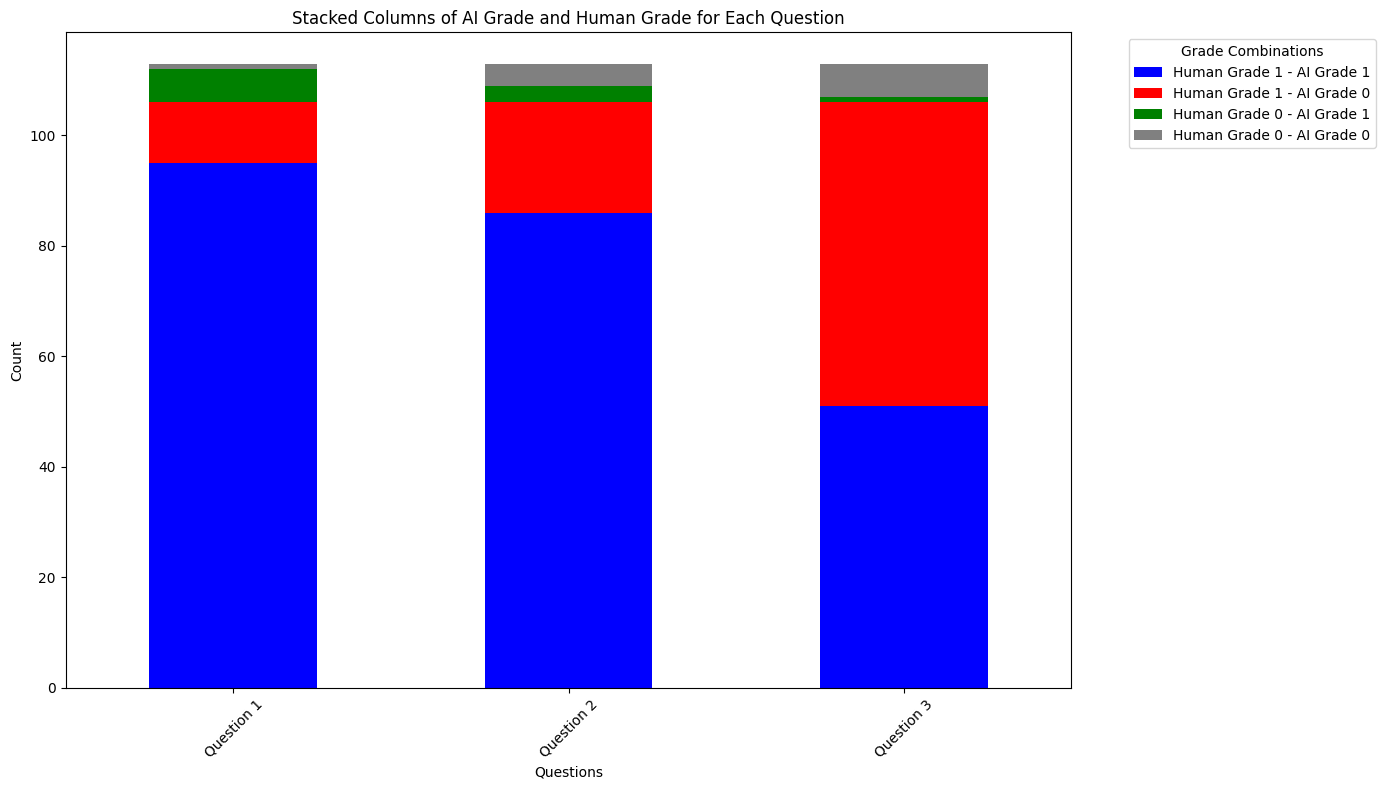

In [211]:
visualizer.plot_confusion_matrix_by_question('Project Overview')

# Visualize Project Overview - V2

In [217]:
test_url = 'test_results/test_result_ prj_overview_100_files_v2.csv'
real_url = 'auto_grading_trainingset/TIPQIC_project_charter_submission_merged.csv'

visualizer = VisualizeTestPred(test_url, real_url)
visualizer.plot_false_positive('Project Overview')

Number of unique file:  132
Number of false positive:  2
----------------------------------------
user id: 596953078
Human Grade: 0.0
Human Comment: I do not see enough detail on problem summary. Include historical data (empirical, or anecdotal) indicating how you know patients are not being open.

I see detail on desired outcomes and benefits.

Criteria: Question 1. Does the value of the 'Problem Summary:' attribute include a detailed (at least 1 sentence) and logical problem statement?
AI Grade: 1
AI Comment: The problem summary is clear and detailed: patients are not opening up fully about their needs due to lack of rapport with staff members, making it difficult to get a clear picture of the patient's needs.

Criteria: Question 2. Does the value of the 'Desired Outcome(s):' attribute include a at least 1 sentence explicitly talking about the expected results/desired outcomes?
AI Grade: 1
AI Comment: The expected result is clear and detailed: patients are able to speak to their ther

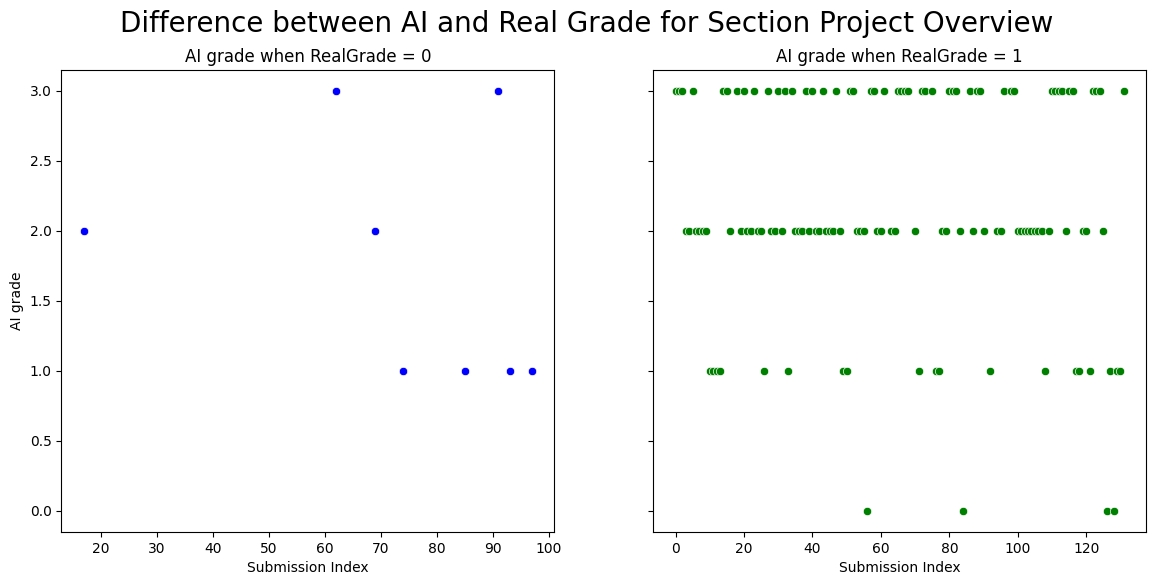

In [219]:
visualizer.visualize_difference_between_AI_and_Real_Grade('Project Overview')

question_list:  ["Question 1. Does the value of the 'Problem Summary:' attribute include a detailed (at least 1 sentence) and logical problem statement?"
 "Question 2. Does the value of the 'Desired Outcome(s):' attribute include a at least 1 sentence explicitly talking about the expected results/desired outcomes?"
 "Question 3. Does the value of the 'Benefits:' attribute include a detailed (at least 1 sentence) explicitly talking about the benefits of this project?"]


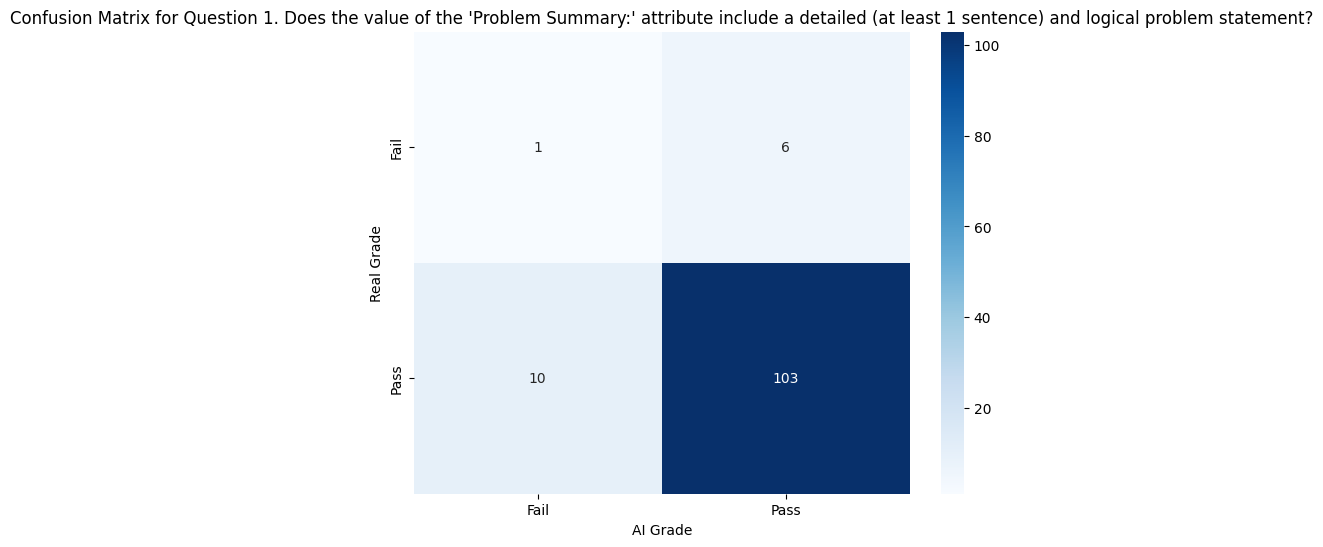

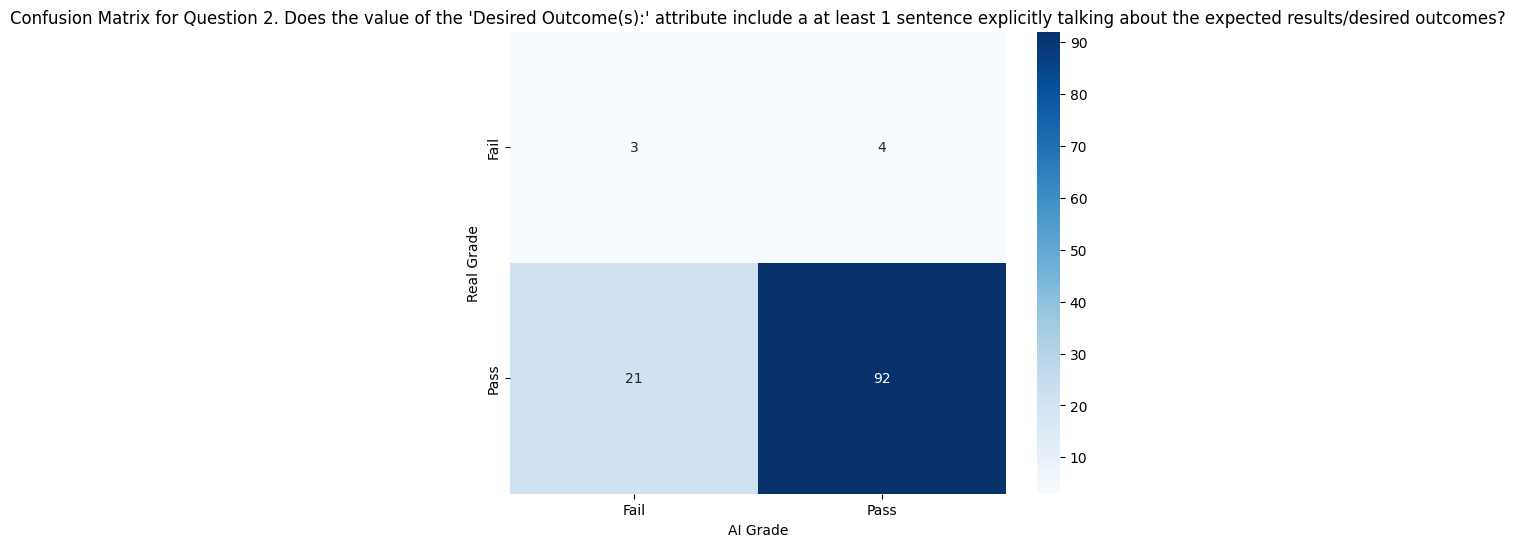

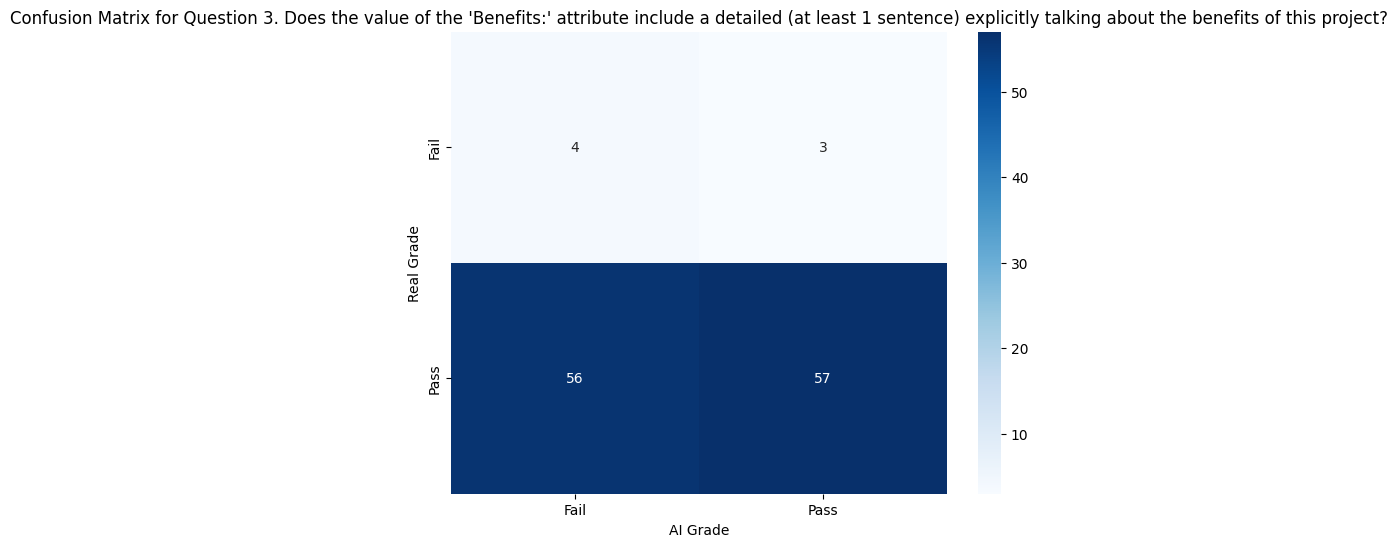

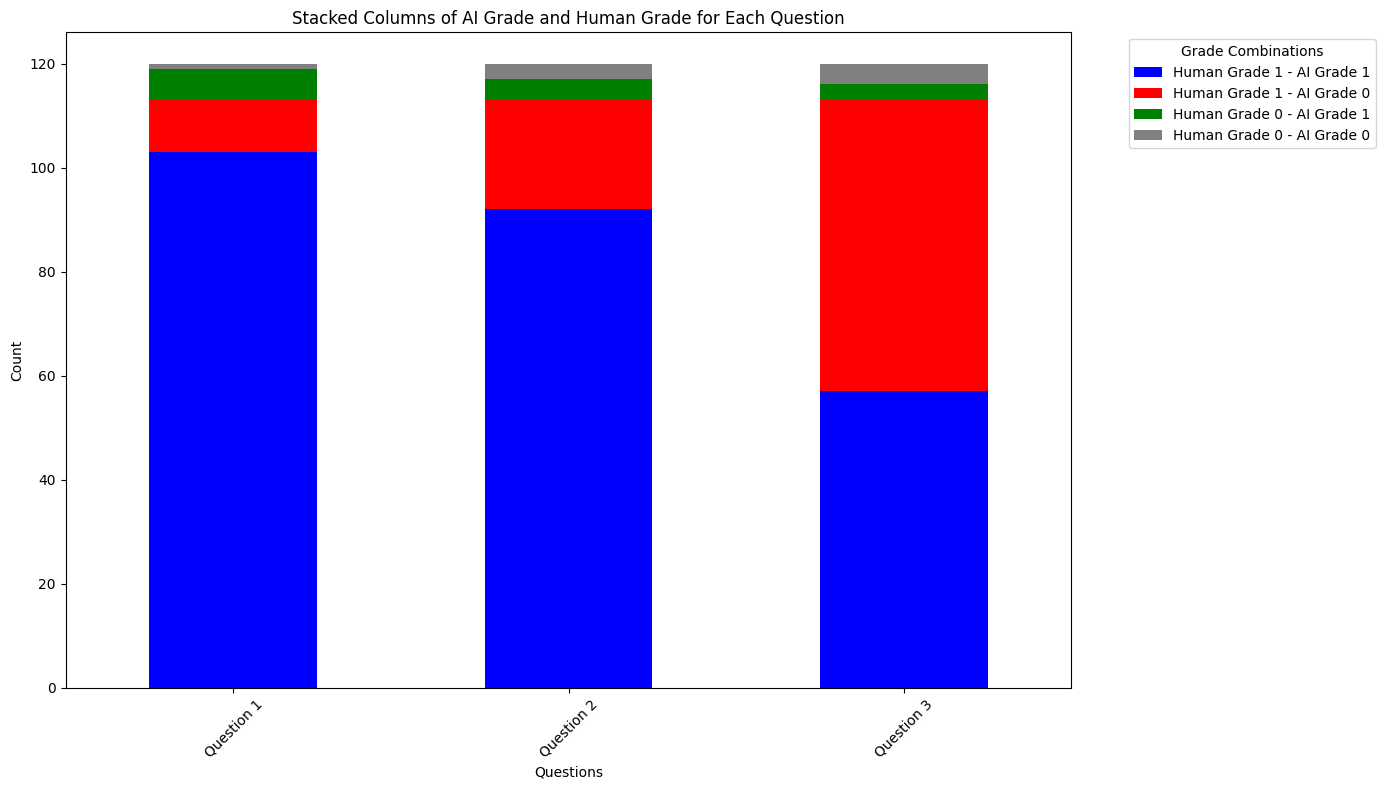

In [218]:
visualizer.plot_confusion_matrix_by_question('Project Overview')